# Proesamiento de los datos, definición y entrenamiento de modelos

## Carga de librerías

In [1]:
import pandas as pd
import sys
import numpy as np
from matplotlib import pyplot as plt
import time
from tqdm import tqdm

pd.options.display.max_columns = 50
pd.options.display.max_rows = 200

import os
os.chdir('/home/fpardo/Matricial_RAW/')
print(os.getcwd())

/home/fpardo/Matricial_RAW


# Carga de fichero SELENE

Se indica que el índice es la primera columna y se parsean las fechas de los eventos registrados en dicho dataset

In [2]:
selene = pd.read_csv('./selene.csv',
                    index_col=0,
                    parse_dates=[3])


/home/fpardo/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Existen diversos campos que representan lo mismo que otros, pero poseen diferentes nombres.
Por ello se unifican y a continuación cambiamos el formato de la fecha para que pase a
contener unicamente hasta el día, eliminando la hora y el minuto.

In [3]:
sel_cod_limpios = selene.copy()

# Se reemplazaran todos los valores de cada sublista por el primero de la misma

reemplazos = [['TEMPER', 'CV_TEMPER'], # TEMPERATURA CORPORAL
             ['SAT', 'sO2', 'ANR_REA_SATURACION_H', 'ANR_REA_SATURACION_A'], # SATURACION OXIGENO
             ['FC', 'UCI_FC'], # FRECUENCIA CARDIACA
             ['TAM', 'TAM2', 'CV_TAM', 'NEO_TAM', 'TAM2'], # TENSION ARTERIAL MEDIA
             ['TAS', 'TAS_PT', 'UCI_TAS', 'BAD_TAS_INI'], # TENSION ARTERIAL SISTOLICA
             ['TAD', 'TAD_PT', 'UCI_TAD', 'BAD_TAD_INI'], # TENSION ARTERIAL DIASTOLICA
             ['IMC', 'CV_IMC', 'NUTRIT_RISK_17'], # INDICE MASA CORPORAL
             ['FR', 'UCI_FR'], # FRECUENCIA RESPIRATORIA
             ['TALLA', 'TALLA_CM']] # ALTURA

for i in reemplazos:
    sel_cod_limpios = sel_cod_limpios.replace(to_replace=i, value = i[0])
sel_cod_limpios[['CODIGO_INDICADOR']].drop_duplicates()
sel_cod_limpios.drop(columns=['AREA', 'HOSPITAL', 'NOMBRE_INDICADOR'],inplace=True)

# Nos quedamos solo con el día
sel_cod_limpios['FECHA_TOMA'] = pd.to_datetime(sel_cod_limpios['FECHA_TOMA']).dt.date

## Eliminación de variables

A continuación se eliminan las variables que no son útiles para la predicción del resultado final, tales como fechas, variables asignadas a una única persona, etc.

In [4]:
variables_descartadas = ['COVID_TTO_OTR COVID_COMORB COVID_PCR2 COVID_PCR2_F COVID_REMD_GPT '+
                         'UCI_SI_CTES_INI_TA COVID_ACOM_DEP COVID_ACOM_DISC COVID_ACOM_DEM2 ' +
                         'COVID_ACOM_HTA COVID_ACOM_DM COVID_ACOM_TTO_CAN COVID_ACOM_INMUNO ' +
                         'COVID_ACOM_FALLE COVID_ACOM_DEM ANR_PARTO_TENS ANR_PARTO_TENS_1 ' +
                         'COVID_REMD_GOT COVID_PCR1 COVID_OXIG_TERAPIA COVID_INI_F COVID_PCR1_F ' +
                         'COVID_TTO_F HTA COVID_REMD_PCR_F COVID_ACOM_EMB COVID_REMD_EVO '+
                         'TALLA PESO IMC COVID_CAND COVID_REMD_CRITE_OPC COVID_REMD_SINTO_F']

variables_descartadas = variables_descartadas[0].split(' ')

indicadores_finales = []

indicadores = sel_cod_limpios['CODIGO_INDICADOR'].unique()

for indicador in indicadores:
    if indicador not in variables_descartadas:
        indicadores_finales.append(indicador)

for indicador in variables_descartadas:
    sel_variables_utiles = sel_cod_limpios[sel_cod_limpios['CODIGO_INDICADOR'] != indicador]

In [6]:
copy = sel_variables_utiles.copy()
var_continuas = ['TEMPER', 'SAT', 'FC', 'TAD', 'TAS', 'TAM', 'FR']

temp = copy[copy['CODIGO_INDICADOR'].isin(['FR'])]
test = temp.pivot_table(index=['ID_PACIENTE', 'FECHA_TOMA'], values = ['CODIGO_INDICADOR'], aggfunc='size').to_frame()

print(i, test[test[range(1)] != 1].count())

test2 = test.reset_index()
test2.columns = ['ID', 'FECHA', 'CONTEO']
print(test2[test2['CONTEO'] != 1].groupby('ID').mean().mean())

['TALLA', 'TALLA_CM'] 0    23702
dtype: int64
CONTEO    3.102817
dtype: float64


Para mantener un único valor por día, se escogen el valor mayor, menor o el último en base al tipo de variable.

In [7]:
var_continuas = ['TEMPER', 'SAT', 'FC', 'TAD', 'TAS', 'TAM', 'FR']
var_cat_bool = ['COVID_TTO', 'COVID_REMD_OXIGEN', 'COVID_REMD_OX_DIS', 'COVID_REMD_HOSP',
                'COVID_REMD_CONSTATES']


copy = sel_variables_utiles.copy()
to_concat = []

for indicador in indicadores_finales:
    temp = copy[copy['CODIGO_INDICADOR'].isin([indicador])]
    
    if indicador in var_continuas:
        if indicador == 'SAT':
            temp = temp.pivot_table(index=['ID_PACIENTE', 'FECHA_TOMA'],
                                    columns='CODIGO_INDICADOR',
                                    values='VALOR_INDICADOR',
                                    aggfunc='min')
        else:
            temp = temp.pivot_table(index=['ID_PACIENTE', 'FECHA_TOMA'],
                                    columns='CODIGO_INDICADOR',
                                    values='VALOR_INDICADOR',
                                    aggfunc='max')
    elif indicador in var_cat_bool:
        temp = temp.pivot_table(index=['ID_PACIENTE', 'FECHA_TOMA'],
                                    columns='CODIGO_INDICADOR',
                                    values='VALOR_INDICADOR',
                                    aggfunc='last')
        
    to_concat.append(temp.copy())

    

selene = pd.concat(to_concat, axis=1)
selene.drop_duplicates(inplace=True)
selene.head()

CODIGO_INDICADOR        FC TEMPER SAT  TAS TAD TAM     COVID_TTO  \
ID_PACIENTE FECHA_TOMA                                             
402556      2021-01-22  70   37,1  96  118  79  92  Dexametasona   
            2021-01-23  70   39,3  93  112  58  76  Dexametasona   
            2021-01-24  65  37,02  95  108  71  83  Dexametasona   
            2021-01-25  56   37,5  99  110  60  77  Dexametasona   
            2021-01-26  68   37,2  98  100  60  73  Dexametasona   

CODIGO_INDICADOR       COVID_REMD_CONSTATES COVID_REMD_OX_DIS  \
ID_PACIENTE FECHA_TOMA                                          
402556      2021-01-22                  NaN               NaN   
            2021-01-23                  NaN               NaN   
            2021-01-24                  NaN               NaN   
            2021-01-25                  NaN               NaN   
            2021-01-26                  NaN               NaN   

CODIGO_INDICADOR       COVID_REMD_OXIGEN COVID_REMD_HOSP   FR  
ID_PACIENTE FECHA_TOMA                                         
402556      2021-01-22               NaN             NaN  NaN  
            2021-01-23               NaN             NaN  NaN  
            2021-01-24               NaN             NaN  NaN  
            2021-01-25               NaN             NaN  NaN  
            2021-01-26               NaN             NaN  NaN

In [8]:
# Hay que medir los nans
test = selene.isna().sum()
variables_a_coger = list(test.sort_values()[:7].index)

Rellenamos los datos hacia atrás, manteniendo así el dato más reciente como el más relevante en caso de encontrar NANs

In [9]:
# Rellenamos los NAN con el siguiente POR PACIENTE
selene.update(selene.groupby(level=0).bfill())

Se incluyen las variables que se agregarán al dataset de estratificación en una lista

In [10]:
variables_4_estrat = []
for var in var_cat_bool:
    temp = selene[selene[var].notnull()][var]
    temp = temp.groupby(level=0).last()
    variables_4_estrat.append(temp.copy())

selene.drop(labels = var_cat_bool, axis = 1, inplace = True)

In [11]:
checkpoint = selene.copy()

Se convierten a numéricas las variables modificando primero aquellas que cuenten con valores no numéricos.

In [12]:
selene = checkpoint.copy()

selene['FC'] = pd.to_numeric(selene['FC'])
selene['FR'] = pd.to_numeric(selene['FR'])
selene['TEMPER'] = selene['TEMPER'].str.replace(',', '.').astype(float)
selene['SAT'] = selene['SAT'].str.replace(',', '.').astype(float)

selene['TAS'] = selene['TAS'].replace('-')
selene['TAS'] = selene['TAS'].str.replace(',', '.').astype(float)
selene['TAD'] = selene['TAD'].replace('-')
selene['TAD'] = selene['TAD'].str.replace(',', '.').astype(float)
selene['TAM'] = selene['TAM'].str.replace(',', '.').astype(float)

Se eliminan los valores que claramente son outliers en base a bibliografía médica.

In [13]:
# Frecuencia Cardiaca
selene['FC'].values[selene['FC'] < 30] = np.NAN
selene['FC'].values[selene['FC'] > 200] = np.NAN

# Temperatura corporal
selene['TEMPER'].values[selene['TEMPER'] < 32] = np.NAN
selene['TEMPER'].values[selene['TEMPER'] > 45] = np.NAN

# Saturación de oxígeno
selene['SAT'].values[selene['SAT'] < 60] = np.NAN
selene['SAT'].values[selene['SAT'] > 100] = np.NAN

# Tensión arterial Sistólico
selene['TAS'].values[selene['TAS'] < 70] = np.NAN
selene['TAS'].values[selene['TAS'] > 220] = np.NAN

# Tensión arterial Diastólica
selene['TAD'].values[selene['TAD'] < 40] = np.NAN
selene['TAD'].values[selene['TAD'] > 120] = np.NAN

# Tensión arterial Media
selene['TAM'].values[selene['TAM'] < 60] = np.NAN
selene['TAM'].values[selene['TAM'] > 160] = np.NAN

# Frecuencia Respiratoria
selene['FR'].values[selene['FR'] < 5] = np.NAN
selene['FR'].values[selene['FR'] > 60] = np.NAN

In [14]:
selene.describe()

CODIGO_INDICADOR,FC,TEMPER,SAT,TAS,TAD,TAM,FR
count,72532.000000,73347.000000,71741.000000,72956.000000,72866.000000,14924.000000,44237.000000
mean,80.413293,36.640935,94.504699,126.769848,73.820602,90.385218,22.864163
std,14.674719,0.612667,4.657120,22.091723,11.565339,11.347525,6.175158
min,30.000000,33.000000,60.000000,70.000000,40.000000,60.000000,5.000000
25%,70.000000,36.300000,93.000000,111.000000,66.000000,83.000000,20.000000
50%,80.000000,36.600000,95.000000,126.000000,74.000000,90.000000,22.000000
75%,90.000000,36.900000,97.000000,141.000000,82.000000,97.000000,25.000000
max,200.000000,43.000000,100.000000,220.000000,120.000000,159.000000,60.000000


Se rellena la Tensión Artierial Media con la fórmula correspondiente que requiere de la Tensión Sistólica y Diastólica.
Además, se rellenan los valores hacia atrás y después hacia delante.
En caso de que queden pacientes con valores nulos, implica que ese paciente no tiene datos para dicha variable.
En este caso, se rellena con la mediana.

In [15]:
selene['TAM'] = selene['TAM'].fillna((selene['TAD'] + (selene['TAS']-selene['TAD'])/3).round(2))
selene.update(selene.groupby(level=0).bfill())
selene.update(selene.groupby(level=0).ffill())

In [16]:
# Analisis de valores faltantes
selene.isnull().values.any()
selene.isnull().groupby(level=0).sum()['FR'].value_counts()
conteo = selene.isnull().groupby(level=0).sum()
conteo.astype(bool).sum(axis=0)

CODIGO_INDICADOR
FC         123
TEMPER      34
SAT        301
TAS         52
TAD         53
TAM         54
FR        2826
dtype: int64

In [17]:
selene = selene.fillna(selene.median())

## Carga de los datos de estratificación

In [18]:
estratificacion = pd.read_csv('./estratificacion.csv', index_col=0)
estratificacion = estratificacion.loc[estratificacion['SITUACION'].isin(['CURADO', 'FALLECIDO'])]

estratificacion = estratificacion[
    ['ID_PACIENTE','SITUACION', 'EDAD', 'SEXO', 'DM', 'IC', 'EPOC','HTA',
     'DEP','VIH','CI','ACV','IRC','CIR','OST','ARTROSIS','ARTRITIS','DEM','DC']].copy()

estratificacion_categoric = ['DM', 'IC', 'EPOC','HTA','DEP','VIH','CI','ACV','IRC',
                             'CIR','OST','ARTROSIS','ARTRITIS','DEM','DC']

estratificacion.set_index(keys = 'ID_PACIENTE', inplace=True)
estratificacion.dropna(inplace=True)

estratificacion['SEXO'] = estratificacion['SEXO'].astype('category')# 0 = Hombre 1 = Mujer
estratificacion['SEXO'] = estratificacion['SEXO'].cat.codes

estratificacion['SITUACION'] = estratificacion['SITUACION'].astype('category')
estratificacion['SITUACION'] = estratificacion['SITUACION'].cat.codes # 1 = FALLECIDO 0 = VIVO


pacientes_estratificacion = estratificacion.index.unique()

Se unifican los datasets manteniendo en ambos casos los pacientes comunes entre ellos.

In [19]:
sel_variables_utiles = selene.copy()

pacientes_selene_set = set(sel_variables_utiles.index.get_level_values(level=0).unique())
pacientes_estratificacion = set(pacientes_estratificacion)
comunes = list(pacientes_estratificacion.intersection(pacientes_selene_set))
comunes.sort()
print(f"Pacientes totales: {len(comunes)}")

selene = sel_variables_utiles[sel_variables_utiles.index.get_level_values(level=0).isin(comunes)].copy()
estratificacion = estratificacion[estratificacion.index.isin(comunes)]

Pacientes totales: 4584


Añadimos las variables extraídas de SELENE que no tienen una dimensión temporal y las agregamos en el fichero de estratificación.

In [21]:
for i, n in enumerate(var_cat_bool):
    estratificacion[n] = variables_4_estrat[i]


estratificacion.loc[estratificacion['COVID_REMD_OX_DIS'].notnull(), 'COVID_REMD_OXIGEN'] = 'Si'
estratificacion.drop(columns = ['COVID_REMD_OX_DIS'], inplace = True)
estratificacion['COVID_REMD_OXIGEN'] = estratificacion['COVID_REMD_OXIGEN'].fillna('No')
estratificacion['COVID_TTO'] = estratificacion['COVID_TTO'].fillna('Dexametasona')
estratificacion['COVID_REMD_HOSP'] = estratificacion['COVID_REMD_HOSP'].fillna('No')
estratificacion['COVID_REMD_CONSTATES'] = estratificacion['COVID_REMD_CONSTATES'].fillna('No')

for i in estratificacion.columns:
    if i not in ['EDAD', 'SEXO', 'SITUACION']:
        estratificacion[i] = estratificacion[i].astype('category')
        estratificacion[i] = estratificacion[i].cat.codes

Se ordena por índice para tener los pacientes ordenados por ID y fecha, por lo que cada paciente mantiene todos sus eventos encadenados y en orden cronológico.
A continuación, extraemos la variable `SITUACIÓN` que es la que queremos predecir.

In [22]:
selene =  selene.sort_index()
estratificacion =  estratificacion.sort_index()

y = estratificacion.pop('SITUACION')

In [23]:
sel_checkpoint = selene.copy()
estr_checkpoint = estratificacion.copy()

In [25]:
selene

CODIGO_INDICADOR          FC  TEMPER   SAT    TAS   TAD     TAM    FR
ID_PACIENTE FECHA_TOMA                                               
402666      2021-01-10  73.0    36.0  90.0  150.0  70.0   96.67  20.0
            2021-01-11  75.0    36.4  88.0  139.0  77.0   97.67  24.0
            2021-01-12  66.0    37.0  92.0  143.0  72.0   95.67  22.0
            2021-01-13  69.0    35.7  89.0  155.0  85.0  108.33  20.0
            2021-01-14  90.0    36.8  74.0  146.0  78.0  100.67  28.0
...                      ...     ...   ...    ...   ...     ...   ...
1529605     2020-09-21  89.0    37.0  89.0  145.0  90.0  108.33  30.0
1530232     2020-04-01  97.0    35.8  95.0  137.0  90.0  105.67  32.0
1530364     2020-03-20  74.0    38.7  94.0  127.0  68.0   87.67  26.0
            2020-03-21  72.0    36.7  90.0  106.0  68.0   80.67  26.0
            2020-03-22  70.0    37.5  92.0  117.0  67.0   83.67  26.0

[43001 rows x 7 columns]

## PROCESAMIENTO DE SELENE POR VENTANAS

In [26]:
from sklearn import preprocessing

def process_selene(selene, estratificacion = None, ventana = 15):

    final = pd.DataFrame()
    
    test = selene.copy()
    columns = test.columns
    test = test.reset_index()
    

    # Por paciente
    for paciente in tqdm(comunes):
        # Cogemos los dias de ventana
        test2 = test[test['ID_PACIENTE'] == paciente][0:ventana].copy()
        test2.reset_index(inplace=True, drop = True)

        # Rellenamos hasta llegar al tamaño de ventana
        if test2.shape[0] < 15:
            test2 = test2.append(test2.iloc[[-1]*(15-test2.shape[0])])
        # Rellenamos los nulos hacia delante. Esto se usa para conservar el ID del usuario
        # en las filas generadas
        test2 = test2.ffill()
        test2.reset_index(inplace = True, drop = True)

        # Si se ha pasado el dataset de estratificación,
        # se realiza la misma operacion que para SELENE
        if estratificacion is not None:
            estr = estratificacion.copy()
            estr.reset_index(inplace = True)
            test4 = estr[estr['ID_PACIENTE'] == paciente]
            test4 = test4.reset_index()
            test4 = test4.rename(columns = {'ID_PACIENTE': 'ID_PACIENTE_DROP'})

            # Repetimos el tamaño de ventana en filas
            test5 = test4.copy()
            if test5.shape[0] < 15:
                test5 = test5.append(test5.iloc[[-1]*(15-test5.shape[0])])
                test5.reset_index(inplace=True)
                test5.drop(columns = ['level_0', 'index'], inplace= True)
                
            # Concatenamos los dataframes y nos cargamos la columna ID que sobra
            test2 = pd.concat((test2.copy(), test5.copy()), axis = 1)
            test2 = test2.drop(columns = ['ID_PACIENTE_DROP'])

        if final.empty:
            final = test2.copy()
        else:
            final = final.append(test2.copy(), ignore_index=True)


    display(final.shape)

    # NUMPY
    x = None
    if estratificacion is None:
        
        for paciente in comunes:

            test = final[final['ID_PACIENTE'] == paciente].copy()
            test = test.drop(columns=['ID_PACIENTE', 'FECHA_TOMA'])
            test2 = test.to_numpy()

            test3 = test2

            if x is None:
                x = test3
            else:
                x = np.append(x, test3, axis = 0)

        # el escalado se hace aquí porque no se puede escalar un array 3d
        scaler_selene = preprocessing.StandardScaler()
        x = scaler_selene.fit_transform(x)

        x = x.reshape(len(comunes),test2.shape[0], test2.shape[1], 1)
        
    else:
        for paciente in comunes:

            test = final[final['ID_PACIENTE'] == paciente].copy()
            test = test.drop(columns=['ID_PACIENTE', 'FECHA_TOMA'])
            test2 = test.to_numpy()
            test2 = test2.flatten()
            test2 = test2.reshape(1,test2.shape[0])


            if x is None:
                x = test2
            else:
                x = np.concatenate((x, test2))

        
    return x

## MLP Y CNN

A continuación se definen la MLP y CNN utilizadas para el modelo multientrada

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate


def create_mlp(dim, regress=False):
    # define our MLP network
    model = Sequential()
    model.add(Dense(4, input_dim=dim, activation="relu"))
   # model.add(Dropout(0.3))
    return model


def create_cnn(width, height, regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, 1)
    # define the model input
    inputs = Input(shape=inputShape)
    x = inputs
    x = Conv2D(4, (3, 3), padding="same")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    #x = Conv2D(2, (2, 2), padding="same")(x)
    x = Flatten()(x)
    x = Dense(4)(x)
    x = Activation("relu")(x)
    #x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.3)(x)
    model = Model(inputs, x)
    # return the CNN
    return model

/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:5

In [28]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tensorflow import keras
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.layers import Flatten, Dense, Input, Activation, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam, SGD, Adadelta
from tensorflow.keras import regularizers

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics


if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
    print("Please install GPU version of TF")


def cnn(selene, estratificacion, y):
    
    estratificacion = estratificacion.values
    
    scaler_estratificacion = preprocessing.StandardScaler()
    estratificacion_scaled = scaler_estratificacion.fit_transform(estratificacion)

    # Split 80-20
    selene_train, selene_test, Y_train, Y_test = train_test_split(selene,
                                                                  y,
                                                                  random_state = 42,
                                                                  train_size = 0.8,
                                                                 stratify=y)
    
    estratificacion_train, estratificacion_test, Y_train, Y_test = train_test_split(estratificacion_scaled,
                                                                                    y,
                                                                                    random_state = 42,
                                                                                    train_size = 0.8,
                                                                                   stratify = y)
    

    # Better have all metrics in one shot
    METRICS = [
          keras.metrics.TruePositives(name='tp'),
          keras.metrics.FalsePositives(name='fp'),
          keras.metrics.TrueNegatives(name='tn'),
          keras.metrics.FalseNegatives(name='fn'), 
          #keras.metrics.BinaryAccuracy(name='accuracy'),
          keras.metrics.Precision(name='precision'),
          keras.metrics.Recall(name='recall'),
    ]

    
    # Llamamos a las funciones que nos crean la MLP y CNN
    
    mlp = create_mlp(estratificacion_train.shape[1])
    cnn = create_cnn(selene_train.shape[2], selene_train.shape[1])
    
    # Concatenamos entradas
    combinedInput = concatenate([mlp.output, cnn.output])
    
    # Capas que procesan ambas entradas en conjunto
    x = Dense(8, activation="relu")(combinedInput)
    # Se ha probado sin bias y con output bias basado en las clases. No parece ayudar
    x = Dense(1, activation="sigmoid", bias_initializer=output_bias)(x)

    
    model = Model(inputs=[mlp.input, cnn.input], outputs=x)
    
    model.summary()
    
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)
    
    n_epoch = 20
    batch_size = 8
    
    
    # Loss inicial
    
    results = model.evaluate([estratificacion_train, selene_train], Y_train, batch_size=batch_size, verbose=0)
    print("Loss: {:0.4f}".format(results[0]))

    
    # Probado con diferentes pesos y SIN pesos. Ayudan, pero no mucho
    history = model.fit(verbose = 0,
        x=[estratificacion_train, selene_train], y=Y_train,
        validation_split=0.2,
        epochs=n_epoch, batch_size=batch_size,
        class_weight={0:0.3, 1:0.7}
    )
    
    
    

    TP = history.history['tp'][-1]
    FP = history.history['fp'][-1]
    TN = history.history['tn'][-1]
    FN = history.history['fn'][-1]
    bacc_train = ((TP/(TP+FN))+(TN/(TN+FP)))/2

    
    TP = history.history['val_tp'][-1]
    FP = history.history['val_fp'][-1]
    TN = history.history['val_tn'][-1]
    FN = history.history['val_fn'][-1]

    bacc_test = ((TP/(TP+FN))+(TN/(TN+FP)))/2
    
    display(model.evaluate(x = [estratificacion_test, selene_test], y = Y_test))
    
    print(f"BACC_TRAIN: {bacc_train}")
    print(f"BACC_TEST: {bacc_test}")
    return bacc_train, bacc_test, model, Y_test, estratificacion_test, selene_test
    

Default GPU Device:/device:GPU:0


Se hace un conteo de las clases positivas y negativas.

In [29]:
y_t = np.ravel(y).astype('int64')
neg, pos = np.bincount(y_t)
print(neg)
print(pos)
initial_bias = np.log([pos/neg])

output_bias = tf.keras.initializers.Constant(initial_bias)


3803
781


In [30]:
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [31]:
mul_bacc_train_list = []
mul_bacc_train_std_list = []
mul_bacc_test_list = []
bacc_test = 0

df_resultados = pd.DataFrame()

y = pd.read_csv('./y_final.csv', header = None).values

window_sizes = range(1, 16)
    
selene = pd.read_csv('./selene_final.csv', index_col = [0, 1])
estratificacion = pd.read_csv('./estratificacion_final.csv', index_col = [0])

n_vars = len(selene.columns) + len(estratificacion.columns)

variables_usadas = list(selene.columns)+list(estratificacion.columns)


for window in window_sizes:
    
    print(f"VENTANA: {window}")
    
    selene_procesado = process_selene(selene, ventana = window)
    
    temp_train = []
    
    # 10 CV
    for i in range(10):
        
        bacc_train, bacc_test, _, _, _, _ = cnn(selene_procesado, estratificacion, y)
        
        temp_train.append(bacc_train)
        

    mul_bacc_train_list.append(np.mean(temp_train))
    mul_bacc_train_std_list.append(np.std(temp_train))
    mul_bacc_test_list.append(bacc_test)


  1%|          | 45/4584 [00:00<00:10, 442.96it/s]

VENTANA: 1


100%|██████████| 4584/4584 [00:12<00:00, 368.82it/s]


(68760, 9)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 15, 7, 4)     40          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 7, 3, 4)      0           conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 84)           0           max_pooling2d[0][0]              
____________________________________________________________________________________________

[0.39075172642975103, 102.0, 120.0, 641.0, 54.0, 0.45945945, 0.65384614]

BACC_TRAIN: 0.7613035440444946
BACC_TEST: 0.7723215818405151
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 15, 7, 4)     40          input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 7, 3, 4)      0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 84)           0           max_pooling2d_1[0][0]            
_______________________________

[0.3996239264242782, 96.0, 107.0, 654.0, 60.0, 0.4729064, 0.61538464]

BACC_TRAIN: 0.757722020149231
BACC_TEST: 0.7095110416412354
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 15, 7, 4)     40          input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 7, 3, 4)      0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 84)           0           max_pooling2d_2[0][0]            
________________________________

[0.3609664033257454, 99.0, 95.0, 666.0, 57.0, 0.5103093, 0.63461536]

BACC_TRAIN: 0.7779157757759094
BACC_TEST: 0.733496367931366
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 15, 7, 4)     40          input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 7, 3, 4)      0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 84)           0           max_pooling2d_3[0][0]            
________________________________

[0.3887730517070192, 106.0, 127.0, 634.0, 50.0, 0.4549356, 0.67948717]

BACC_TRAIN: 0.7647942900657654
BACC_TEST: 0.7211405038833618
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 15, 7, 4)     40          input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 7, 3, 4)      0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 84)           0           max_pooling2d_4[0][0]            
_______________________________

[0.37764523427775015, 106.0, 109.0, 652.0, 50.0, 0.49302325, 0.67948717]

BACC_TRAIN: 0.7482286691665649
BACC_TEST: 0.7675608396530151
Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 15, 7, 4)     40          input_6[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 7, 3, 4)      0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
flatten_5 (Flatten)             (None, 84)           0           max_pooling2d_5[0][0]            
______________________________

[0.36470672796960746, 105.0, 106.0, 655.0, 51.0, 0.49763033, 0.6730769]

BACC_TRAIN: 0.7471112012863159
BACC_TEST: 0.7513523101806641
Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 15, 7, 4)     40          input_7[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 7, 3, 4)      0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
flatten_6 (Flatten)             (None, 84)           0           max_pooling2d_6[0][0]            
______________________________

[0.3519069578421415, 98.0, 95.0, 666.0, 58.0, 0.507772, 0.6282051]

BACC_TRAIN: 0.7646821737289429
BACC_TEST: 0.7515339255332947
Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 15, 7, 4)     40          input_8[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 7, 3, 4)      0           conv2d_7[0][0]                   
__________________________________________________________________________________________________
flatten_7 (Flatten)             (None, 84)           0           max_pooling2d_7[0][0]            
______________________________

[0.36611138623829365, 87.0, 96.0, 665.0, 69.0, 0.47540984, 0.5576923]

BACC_TRAIN: 0.760596752166748
BACC_TEST: 0.7059372663497925
Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 15, 7, 4)     40          input_9[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 7, 3, 4)      0           conv2d_8[0][0]                   
__________________________________________________________________________________________________
flatten_8 (Flatten)             (None, 84)           0           max_pooling2d_8[0][0]            
_______________________________

[0.35966041456652054, 94.0, 100.0, 661.0, 62.0, 0.48453608, 0.6025641]

BACC_TRAIN: 0.7619434595108032
BACC_TEST: 0.7266277074813843
Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 15, 7, 4)     40          input_10[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 7, 3, 4)      0           conv2d_9[0][0]                   
__________________________________________________________________________________________________
flatten_9 (Flatten)             (None, 84)           0           max_pooling2d_9[0][0]            
______________________________

[0.37008385036867864, 91.0, 97.0, 664.0, 65.0, 0.48404256, 0.5833333]

  1%|          | 44/4584 [00:00<00:10, 435.89it/s]

BACC_TRAIN: 0.7541847229003906
BACC_TEST: 0.7042897939682007
VENTANA: 2


100%|██████████| 4584/4584 [00:11<00:00, 383.13it/s]


(68760, 9)

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 15, 7, 4)     40          input_11[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_10[0][0]                  
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 84)           0           max_pooling2d_10[0][0]           
___________________________________________________________________________________________

[0.3450130999348286, 99.0, 92.0, 669.0, 57.0, 0.5183246, 0.63461536]

BACC_TRAIN: 0.783118486404419
BACC_TEST: 0.7469547986984253
Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 15, 7, 4)     40          input_12[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_11 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_11[0][0]                  
__________________________________________________________________________________________________
flatten_11 (Flatten)            (None, 84)           0           max_pooling2d_11[0][0]           
_______________________________

[0.3508493585700947, 85.0, 69.0, 692.0, 71.0, 0.5519481, 0.5448718]

BACC_TRAIN: 0.7797411680221558
BACC_TEST: 0.7302857637405396
Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 15, 7, 4)     40          input_13[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_12[0][0]                  
__________________________________________________________________________________________________
flatten_12 (Flatten)            (None, 84)           0           max_pooling2d_12[0][0]           
______________________________

[0.36320520510070325, 103.0, 97.0, 664.0, 53.0, 0.515, 0.6602564]

BACC_TRAIN: 0.7591354846954346
BACC_TEST: 0.7665555477142334
Model: "model_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 15, 7, 4)     40          input_14[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_13[0][0]                  
__________________________________________________________________________________________________
flatten_13 (Flatten)            (None, 84)           0           max_pooling2d_13[0][0]           
______________________________

[0.35155681591387533, 99.0, 93.0, 668.0, 57.0, 0.515625, 0.63461536]

BACC_TRAIN: 0.7813385128974915
BACC_TEST: 0.7546472549438477
Model: "model_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 15, 7, 4)     40          input_15[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_14 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_14[0][0]                  
__________________________________________________________________________________________________
flatten_14 (Flatten)            (None, 84)           0           max_pooling2d_14[0][0]           
______________________________

[0.34925878259191856, 95.0, 87.0, 674.0, 61.0, 0.521978, 0.60897434]

BACC_TRAIN: 0.7713210582733154
BACC_TEST: 0.7453073859214783
Model: "model_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 15, 7, 4)     40          input_16[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_15 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_15[0][0]                  
__________________________________________________________________________________________________
flatten_15 (Flatten)            (None, 84)           0           max_pooling2d_15[0][0]           
______________________________

[0.3457241222148633, 90.0, 86.0, 675.0, 66.0, 0.5113636, 0.5769231]

BACC_TRAIN: 0.765046238899231
BACC_TEST: 0.7386202812194824
Model: "model_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 15, 7, 4)     40          input_17[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_16 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_16[0][0]                  
__________________________________________________________________________________________________
flatten_16 (Flatten)            (None, 84)           0           max_pooling2d_16[0][0]           
_______________________________

[0.34974546904392306, 97.0, 94.0, 667.0, 59.0, 0.5078534, 0.6217949]

BACC_TRAIN: 0.7740596532821655
BACC_TEST: 0.7587658166885376
Model: "model_35"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 15, 7, 4)     40          input_18[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_17 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_17[0][0]                  
__________________________________________________________________________________________________
flatten_17 (Flatten)            (None, 84)           0           max_pooling2d_17[0][0]           
______________________________

[0.36390772429391366, 111.0, 104.0, 657.0, 45.0, 0.51627904, 0.71153843]

BACC_TRAIN: 0.7655715346336365
BACC_TEST: 0.7669187784194946
Model: "model_37"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 15, 7, 4)     40          input_19[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_18 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_18[0][0]                  
__________________________________________________________________________________________________
flatten_18 (Flatten)            (None, 84)           0           max_pooling2d_18[0][0]           
______________________________

[0.3569812865982659, 103.0, 100.0, 661.0, 53.0, 0.5073892, 0.6602564]

BACC_TRAIN: 0.7778704166412354
BACC_TEST: 0.7229695320129395
Model: "model_39"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 15, 7, 4)     40          input_20[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_19 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
flatten_19 (Flatten)            (None, 84)           0           max_pooling2d_19[0][0]           
______________________________

[0.3575626498935267, 85.0, 79.0, 682.0, 71.0, 0.51829267, 0.5448718]

  1%|          | 46/4584 [00:00<00:09, 454.97it/s]

BACC_TRAIN: 0.765684962272644
BACC_TEST: 0.7235143780708313
VENTANA: 3


100%|██████████| 4584/4584 [00:11<00:00, 386.71it/s]


(68760, 9)

Model: "model_41"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 15, 7, 4)     40          input_21[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_20 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
flatten_20 (Flatten)            (None, 84)           0           max_pooling2d_20[0][0]           
___________________________________________________________________________________________

[0.31988598128441503, 89.0, 69.0, 692.0, 67.0, 0.56329113, 0.57051283]

BACC_TRAIN: 0.7775957584381104
BACC_TEST: 0.7408125400543213
Model: "model_43"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 15, 7, 4)     40          input_22[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_21 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_21[0][0]                  
__________________________________________________________________________________________________
flatten_21 (Flatten)            (None, 84)           0           max_pooling2d_21[0][0]           
______________________________

[0.33764830735413565, 107.0, 94.0, 667.0, 49.0, 0.5323383, 0.6858974]

BACC_TRAIN: 0.7892786264419556
BACC_TEST: 0.7546472549438477
Model: "model_45"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 15, 7, 4)     40          input_23[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_22 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_22[0][0]                  
__________________________________________________________________________________________________
flatten_22 (Flatten)            (None, 84)           0           max_pooling2d_22[0][0]           
______________________________

[0.3462799713746802, 108.0, 105.0, 656.0, 48.0, 0.5070422, 0.6923077]

BACC_TRAIN: 0.7797625660896301
BACC_TEST: 0.7753375768661499
Model: "model_47"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 15, 7, 4)     40          input_24[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_23 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_23[0][0]                  
__________________________________________________________________________________________________
flatten_23 (Flatten)            (None, 84)           0           max_pooling2d_23[0][0]           
______________________________

[0.3647812342955736, 109.0, 118.0, 643.0, 47.0, 0.4801762, 0.69871795]

BACC_TRAIN: 0.785923957824707
BACC_TEST: 0.7559314370155334
Model: "model_49"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 15, 7, 4)     40          input_25[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_24 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_24[0][0]                  
__________________________________________________________________________________________________
flatten_24 (Flatten)            (None, 84)           0           max_pooling2d_24[0][0]           
_______________________________

[0.32394927749846986, 94.0, 69.0, 692.0, 62.0, 0.5766871, 0.6025641]

BACC_TRAIN: 0.7737385034561157
BACC_TEST: 0.7486865520477295
Model: "model_51"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 15, 7, 4)     40          input_26[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_25 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_25[0][0]                  
__________________________________________________________________________________________________
flatten_25 (Flatten)            (None, 84)           0           max_pooling2d_25[0][0]           
______________________________

[0.32516687442198183, 92.0, 67.0, 694.0, 64.0, 0.5786164, 0.5897436]

BACC_TRAIN: 0.7686957120895386
BACC_TEST: 0.7455732822418213
Model: "model_53"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 15, 7, 4)     40          input_27[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_26 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_26[0][0]                  
__________________________________________________________________________________________________
flatten_26 (Flatten)            (None, 84)           0           max_pooling2d_26[0][0]           
______________________________

[0.32913857357192583, 103.0, 79.0, 682.0, 53.0, 0.56593406, 0.6602564]

BACC_TRAIN: 0.7741038203239441
BACC_TEST: 0.743562638759613
Model: "model_55"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 15, 7, 4)     40          input_28[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_27 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_27[0][0]                  
__________________________________________________________________________________________________
flatten_27 (Flatten)            (None, 84)           0           max_pooling2d_27[0][0]           
_______________________________

[0.34281372607989297, 104.0, 105.0, 656.0, 52.0, 0.49760765, 0.6666667]

BACC_TRAIN: 0.7832092046737671
BACC_TEST: 0.7666398286819458
Model: "model_57"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 15, 7, 4)     40          input_29[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_28 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_28[0][0]                  
__________________________________________________________________________________________________
flatten_28 (Flatten)            (None, 84)           0           max_pooling2d_28[0][0]           
______________________________

[0.3198063417440412, 98.0, 79.0, 682.0, 58.0, 0.5536723, 0.6282051]

BACC_TRAIN: 0.7789424657821655
BACC_TEST: 0.7663609981536865
Model: "model_59"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 15, 7, 4)     40          input_30[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_29 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_29[0][0]                  
__________________________________________________________________________________________________
flatten_29 (Flatten)            (None, 84)           0           max_pooling2d_29[0][0]           
______________________________

[0.32819097499681016, 93.0, 68.0, 693.0, 63.0, 0.57763976, 0.59615386]

  1%|          | 46/4584 [00:00<00:09, 458.35it/s]

BACC_TRAIN: 0.7735570669174194
BACC_TEST: 0.7342227697372437
VENTANA: 4


100%|██████████| 4584/4584 [00:12<00:00, 375.46it/s]


(68760, 9)

Model: "model_61"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 15, 7, 4)     40          input_31[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_30 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_30[0][0]                  
__________________________________________________________________________________________________
flatten_30 (Flatten)            (None, 84)           0           max_pooling2d_30[0][0]           
___________________________________________________________________________________________

[0.3335828825002668, 94.0, 74.0, 687.0, 62.0, 0.5595238, 0.6025641]

BACC_TRAIN: 0.7817705869674683
BACC_TEST: 0.7626055479049683
Model: "model_63"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 15, 7, 4)     40          input_32[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_31 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_31[0][0]                  
__________________________________________________________________________________________________
flatten_31 (Flatten)            (None, 84)           0           max_pooling2d_31[0][0]           
______________________________

[0.31908957414824674, 94.0, 63.0, 698.0, 62.0, 0.5987261, 0.6025641]

BACC_TRAIN: 0.7822266221046448
BACC_TEST: 0.7389835119247437
Model: "model_65"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 15, 7, 4)     40          input_33[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_32 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_32[0][0]                  
__________________________________________________________________________________________________
flatten_32 (Flatten)            (None, 84)           0           max_pooling2d_32[0][0]           
______________________________

[0.33679881223935465, 98.0, 85.0, 676.0, 58.0, 0.5355191, 0.6282051]

BACC_TRAIN: 0.7846466302871704
BACC_TEST: 0.7330358624458313
Model: "model_67"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 15, 7, 4)     40          input_34[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_33 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_33[0][0]                  
__________________________________________________________________________________________________
flatten_33 (Flatten)            (None, 84)           0           max_pooling2d_33[0][0]           
______________________________

[0.31992963037678046, 100.0, 70.0, 691.0, 56.0, 0.5882353, 0.64102566]

BACC_TRAIN: 0.7513086795806885
BACC_TEST: 0.7706611752510071
Model: "model_69"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 15, 7, 4)     40          input_35[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_34 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_34[0][0]                  
__________________________________________________________________________________________________
flatten_34 (Flatten)            (None, 84)           0           max_pooling2d_34[0][0]           
______________________________

[0.3285443168560057, 100.0, 86.0, 675.0, 56.0, 0.53763443, 0.64102566]

BACC_TRAIN: 0.7683531045913696
BACC_TEST: 0.7819273471832275
Model: "model_71"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_36 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_35 (Conv2D)              (None, 15, 7, 4)     40          input_36[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_35 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_35[0][0]                  
__________________________________________________________________________________________________
flatten_35 (Flatten)            (None, 84)           0           max_pooling2d_35[0][0]           
______________________________

[0.3304639242207601, 102.0, 91.0, 670.0, 54.0, 0.5284974, 0.65384614]

BACC_TRAIN: 0.785605251789093
BACC_TEST: 0.763344943523407
Model: "model_73"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 15, 7, 4)     40          input_37[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_36 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_36[0][0]                  
__________________________________________________________________________________________________
flatten_36 (Flatten)            (None, 84)           0           max_pooling2d_36[0][0]           
________________________________

[0.33795564463250377, 97.0, 79.0, 682.0, 59.0, 0.5511364, 0.6217949]

BACC_TRAIN: 0.7745383977890015
BACC_TEST: 0.7454890012741089
Model: "model_75"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_38 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 15, 7, 4)     40          input_38[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_37 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_37[0][0]                  
__________________________________________________________________________________________________
flatten_37 (Flatten)            (None, 84)           0           max_pooling2d_37[0][0]           
______________________________

[0.3220111235017475, 98.0, 62.0, 699.0, 58.0, 0.6125, 0.6282051]

BACC_TRAIN: 0.7716385126113892
BACC_TEST: 0.7745981812477112
Model: "model_77"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 15, 7, 4)     40          input_39[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_38 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_38[0][0]                  
__________________________________________________________________________________________________
flatten_38 (Flatten)            (None, 84)           0           max_pooling2d_38[0][0]           
______________________________

[0.31889244047935034, 94.0, 76.0, 685.0, 62.0, 0.5529412, 0.6025641]

BACC_TRAIN: 0.7976760864257812
BACC_TEST: 0.7711216807365417
Model: "model_79"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_40 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 15, 7, 4)     40          input_40[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_39 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_39[0][0]                  
__________________________________________________________________________________________________
flatten_39 (Flatten)            (None, 84)           0           max_pooling2d_39[0][0]           
______________________________

[0.31908331335305906, 89.0, 66.0, 695.0, 67.0, 0.57419354, 0.57051283]

  1%|          | 45/4584 [00:00<00:10, 444.54it/s]

BACC_TRAIN: 0.7706130743026733
BACC_TEST: 0.7501524686813354
VENTANA: 5


100%|██████████| 4584/4584 [00:11<00:00, 382.43it/s]


(68760, 9)

Model: "model_81"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 15, 7, 4)     40          input_41[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_40 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_40[0][0]                  
__________________________________________________________________________________________________
flatten_40 (Flatten)            (None, 84)           0           max_pooling2d_40[0][0]           
___________________________________________________________________________________________

[0.30630970366843524, 95.0, 57.0, 704.0, 61.0, 0.625, 0.60897434]

BACC_TRAIN: 0.7874066829681396
BACC_TEST: 0.7675479054450989
Model: "model_83"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_42 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              (None, 15, 7, 4)     40          input_42[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_41 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_41[0][0]                  
__________________________________________________________________________________________________
flatten_41 (Flatten)            (None, 84)           0           max_pooling2d_41[0][0]           
______________________________

[0.3042450691192465, 105.0, 71.0, 690.0, 51.0, 0.59659094, 0.6730769]

BACC_TRAIN: 0.7724850177764893
BACC_TEST: 0.7745981812477112
Model: "model_85"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_43 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 15, 7, 4)     40          input_43[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_42 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_42[0][0]                  
__________________________________________________________________________________________________
flatten_42 (Flatten)            (None, 84)           0           max_pooling2d_42[0][0]           
______________________________

[0.33098835763780476, 99.0, 82.0, 679.0, 57.0, 0.5469613, 0.63461536]

BACC_TRAIN: 0.7856947183609009
BACC_TEST: 0.7760640382766724
Model: "model_87"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_44 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 15, 7, 4)     40          input_44[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_43 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_43[0][0]                  
__________________________________________________________________________________________________
flatten_43 (Flatten)            (None, 84)           0           max_pooling2d_43[0][0]           
______________________________

[0.3179337512153316, 107.0, 88.0, 673.0, 49.0, 0.548718, 0.6858974]

BACC_TRAIN: 0.788913369178772
BACC_TEST: 0.779274582862854
Model: "model_89"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_45 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 15, 7, 4)     40          input_45[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_44 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_44[0][0]                  
__________________________________________________________________________________________________
flatten_44 (Flatten)            (None, 84)           0           max_pooling2d_44[0][0]           
________________________________

[0.31585072210076853, 99.0, 65.0, 696.0, 57.0, 0.60365856, 0.63461536]

BACC_TRAIN: 0.7883641719818115
BACC_TEST: 0.7934595346450806
Model: "model_91"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_46 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 15, 7, 4)     40          input_46[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_45 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_45[0][0]                  
__________________________________________________________________________________________________
flatten_45 (Flatten)            (None, 84)           0           max_pooling2d_45[0][0]           
______________________________

[0.3131975568302845, 96.0, 58.0, 703.0, 60.0, 0.6233766, 0.61538464]

BACC_TRAIN: 0.7895973920822144
BACC_TEST: 0.7745981812477112
Model: "model_93"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_47 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_46 (Conv2D)              (None, 15, 7, 4)     40          input_47[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_46 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_46[0][0]                  
__________________________________________________________________________________________________
flatten_46 (Flatten)            (None, 84)           0           max_pooling2d_46[0][0]           
______________________________

[0.33797141194603564, 103.0, 93.0, 668.0, 53.0, 0.5255102, 0.6602564]

BACC_TRAIN: 0.7859920263290405
BACC_TEST: 0.7769850492477417
Model: "model_95"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_48 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 15, 7, 4)     40          input_48[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_47 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_47[0][0]                  
__________________________________________________________________________________________________
flatten_47 (Flatten)            (None, 84)           0           max_pooling2d_47[0][0]           
______________________________

[0.30789122903555016, 99.0, 66.0, 695.0, 57.0, 0.6, 0.63461536]

BACC_TRAIN: 0.784600019454956
BACC_TEST: 0.7872329354286194
Model: "model_97"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_49 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 15, 7, 4)     40          input_49[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_48 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_48[0][0]                  
__________________________________________________________________________________________________
flatten_48 (Flatten)            (None, 84)           0           max_pooling2d_48[0][0]           
_______________________________

[0.3249811921735886, 103.0, 81.0, 680.0, 53.0, 0.5597826, 0.6602564]

BACC_TRAIN: 0.7897573709487915
BACC_TEST: 0.7930963039398193
Model: "model_99"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_50 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 15, 7, 4)     40          input_50[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_49 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_49[0][0]                  
__________________________________________________________________________________________________
flatten_49 (Flatten)            (None, 84)           0           max_pooling2d_49[0][0]           
______________________________

[0.30656868908371504, 100.0, 72.0, 689.0, 56.0, 0.5813953, 0.64102566]

  1%|          | 37/4584 [00:00<00:12, 362.08it/s]

BACC_TRAIN: 0.8045203685760498
BACC_TEST: 0.7934595346450806
VENTANA: 6


100%|██████████| 4584/4584 [00:12<00:00, 381.81it/s]


(68760, 9)

Model: "model_101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_51 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (None, 15, 7, 4)     40          input_51[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_50 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_50[0][0]                  
__________________________________________________________________________________________________
flatten_50 (Flatten)            (None, 84)           0           max_pooling2d_50[0][0]           
__________________________________________________________________________________________

[0.31979606537028515, 108.0, 90.0, 671.0, 48.0, 0.54545456, 0.6923077]

BACC_TRAIN: 0.7876586318016052
BACC_TEST: 0.7705768346786499
Model: "model_103"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_52 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_51 (Conv2D)              (None, 15, 7, 4)     40          input_52[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_51 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_51[0][0]                  
__________________________________________________________________________________________________
flatten_51 (Flatten)            (None, 84)           0           max_pooling2d_51[0][0]           
_____________________________

[0.3121574795688122, 108.0, 74.0, 687.0, 48.0, 0.5934066, 0.6923077]

BACC_TRAIN: 0.7913988828659058
BACC_TEST: 0.7885171175003052
Model: "model_105"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_53 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 15, 7, 4)     40          input_53[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_52 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_52[0][0]                  
__________________________________________________________________________________________________
flatten_52 (Flatten)            (None, 84)           0           max_pooling2d_52[0][0]           
_____________________________

[0.3036451533095527, 107.0, 74.0, 687.0, 49.0, 0.59116024, 0.6858974]

BACC_TRAIN: 0.8034017086029053
BACC_TEST: 0.7916304469108582
Model: "model_107"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_54 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, 15, 7, 4)     40          input_54[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_53 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_53[0][0]                  
__________________________________________________________________________________________________
flatten_53 (Flatten)            (None, 84)           0           max_pooling2d_53[0][0]           
_____________________________

[0.29933061168784014, 106.0, 78.0, 683.0, 50.0, 0.57608694, 0.67948717]

BACC_TRAIN: 0.7927467823028564
BACC_TEST: 0.7970333099365234
Model: "model_109"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_55 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_54 (Conv2D)              (None, 15, 7, 4)     40          input_55[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_54 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_54[0][0]                  
__________________________________________________________________________________________________
flatten_54 (Flatten)            (None, 84)           0           max_pooling2d_54[0][0]           
_____________________________

[0.3096785982796514, 108.0, 76.0, 685.0, 48.0, 0.5869565, 0.6923077]

BACC_TRAIN: 0.8034243583679199
BACC_TEST: 0.7808247804641724
Model: "model_111"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_56 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_55 (Conv2D)              (None, 15, 7, 4)     40          input_56[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_55 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_55[0][0]                  
__________________________________________________________________________________________________
flatten_55 (Flatten)            (None, 84)           0           max_pooling2d_55[0][0]           
_____________________________

[0.29591635085699214, 94.0, 66.0, 695.0, 62.0, 0.5875, 0.6025641]

BACC_TRAIN: 0.8089231848716736
BACC_TEST: 0.7998676300048828
Model: "model_113"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_57 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_56 (Conv2D)              (None, 15, 7, 4)     40          input_57[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_56 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_56[0][0]                  
__________________________________________________________________________________________________
flatten_56 (Flatten)            (None, 84)           0           max_pooling2d_56[0][0]           
_____________________________

[0.3391501098188735, 107.0, 97.0, 664.0, 49.0, 0.5245098, 0.6858974]

BACC_TRAIN: 0.806643009185791
BACC_TEST: 0.7855011820793152
Model: "model_115"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_58 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 15, 7, 4)     40          input_58[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_57 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_57[0][0]                  
__________________________________________________________________________________________________
flatten_57 (Flatten)            (None, 84)           0           max_pooling2d_57[0][0]           
______________________________

[0.31785563940960293, 111.0, 86.0, 675.0, 45.0, 0.56345177, 0.71153843]

BACC_TRAIN: 0.7960774898529053
BACC_TEST: 0.8049073219299316
Model: "model_117"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_59 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 15, 7, 4)     40          input_59[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_58 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_58[0][0]                  
__________________________________________________________________________________________________
flatten_58 (Flatten)            (None, 84)           0           max_pooling2d_58[0][0]           
_____________________________

[0.2843993923331295, 101.0, 56.0, 705.0, 55.0, 0.6433121, 0.6474359]

BACC_TRAIN: 0.8151764869689941
BACC_TEST: 0.7859486937522888
Model: "model_119"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_60 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 15, 7, 4)     40          input_60[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_59 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_59[0][0]                  
__________________________________________________________________________________________________
flatten_59 (Flatten)            (None, 84)           0           max_pooling2d_59[0][0]           
_____________________________

[0.3137879770903187, 113.0, 92.0, 669.0, 43.0, 0.5512195, 0.724359]

  1%|          | 47/4584 [00:00<00:09, 461.46it/s]

BACC_TRAIN: 0.8127363920211792
BACC_TEST: 0.7802799344062805
VENTANA: 7


100%|██████████| 4584/4584 [00:11<00:00, 391.91it/s]


(68760, 9)

Model: "model_121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_61 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 15, 7, 4)     40          input_61[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_60 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_60[0][0]                  
__________________________________________________________________________________________________
flatten_60 (Flatten)            (None, 84)           0           max_pooling2d_60[0][0]           
__________________________________________________________________________________________

[0.31583877549696643, 114.0, 97.0, 664.0, 42.0, 0.54028434, 0.7307692]

BACC_TRAIN: 0.8064603805541992
BACC_TEST: 0.8037203550338745
Model: "model_123"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_62 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_61 (Conv2D)              (None, 15, 7, 4)     40          input_62[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_61 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_61[0][0]                  
__________________________________________________________________________________________________
flatten_61 (Flatten)            (None, 84)           0           max_pooling2d_61[0][0]           
_____________________________

[0.29788083728553166, 115.0, 96.0, 665.0, 41.0, 0.5450237, 0.73717946]

BACC_TRAIN: 0.805182933807373
BACC_TEST: 0.8070152997970581
Model: "model_125"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_63 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_62 (Conv2D)              (None, 15, 7, 4)     40          input_63[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_62 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_62[0][0]                  
__________________________________________________________________________________________________
flatten_62 (Flatten)            (None, 84)           0           max_pooling2d_62[0][0]           
______________________________

[0.351996497636013, 114.0, 118.0, 643.0, 42.0, 0.49137932, 0.7307692]

BACC_TRAIN: 0.788365364074707
BACC_TEST: 0.7812010049819946
Model: "model_127"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_64 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_63 (Conv2D)              (None, 15, 7, 4)     40          input_64[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_63 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_63[0][0]                  
__________________________________________________________________________________________________
flatten_63 (Flatten)            (None, 84)           0           max_pooling2d_63[0][0]           
______________________________

[0.3058662532850076, 97.0, 81.0, 680.0, 59.0, 0.5449438, 0.6217949]

BACC_TRAIN: 0.8032656311988831
BACC_TEST: 0.8241318464279175
Model: "model_129"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_65 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 15, 7, 4)     40          input_65[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_64 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_64[0][0]                  
__________________________________________________________________________________________________
flatten_64 (Flatten)            (None, 84)           0           max_pooling2d_64[0][0]           
_____________________________

[0.2963551031659188, 103.0, 75.0, 686.0, 53.0, 0.57865167, 0.6602564]

BACC_TRAIN: 0.8301687240600586
BACC_TEST: 0.8027993440628052
Model: "model_131"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_66 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_65 (Conv2D)              (None, 15, 7, 4)     40          input_66[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_65 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_65[0][0]                  
__________________________________________________________________________________________________
flatten_65 (Flatten)            (None, 84)           0           max_pooling2d_65[0][0]           
_____________________________

[0.28963543789922347, 105.0, 68.0, 693.0, 51.0, 0.6069364, 0.6730769]

BACC_TRAIN: 0.8184619545936584
BACC_TEST: 0.7965728044509888
Model: "model_133"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_67 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_66 (Conv2D)              (None, 15, 7, 4)     40          input_67[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_66 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_66[0][0]                  
__________________________________________________________________________________________________
flatten_66 (Flatten)            (None, 84)           0           max_pooling2d_66[0][0]           
_____________________________

[0.3034485458612702, 94.0, 66.0, 695.0, 62.0, 0.5875, 0.6025641]

BACC_TRAIN: 0.8128031492233276
BACC_TEST: 0.7744165658950806
Model: "model_135"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_68 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_67 (Conv2D)              (None, 15, 7, 4)     40          input_68[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_67 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_67[0][0]                  
__________________________________________________________________________________________________
flatten_67 (Flatten)            (None, 84)           0           max_pooling2d_67[0][0]           
_____________________________

[0.2919604510491391, 94.0, 59.0, 702.0, 62.0, 0.6143791, 0.6025641]

BACC_TRAIN: 0.803469717502594
BACC_TEST: 0.7718481421470642
Model: "model_137"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_69 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_68 (Conv2D)              (None, 15, 7, 4)     40          input_69[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_68 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_68[0][0]                  
__________________________________________________________________________________________________
flatten_68 (Flatten)            (None, 84)           0           max_pooling2d_68[0][0]           
______________________________

[0.27746824752803456, 108.0, 69.0, 692.0, 48.0, 0.6101695, 0.6923077]

BACC_TRAIN: 0.7989547252655029
BACC_TEST: 0.7893408536911011
Model: "model_139"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_70 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_69 (Conv2D)              (None, 15, 7, 4)     40          input_70[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_69 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_69[0][0]                  
__________________________________________________________________________________________________
flatten_69 (Flatten)            (None, 84)           0           max_pooling2d_69[0][0]           
_____________________________

[0.2998203458091815, 105.0, 76.0, 685.0, 51.0, 0.5801105, 0.6730769]

  1%|          | 44/4584 [00:00<00:10, 434.02it/s]

BACC_TRAIN: 0.8144232034683228
BACC_TEST: 0.7824721932411194
VENTANA: 8


100%|██████████| 4584/4584 [00:11<00:00, 387.80it/s]


(68760, 9)

Model: "model_141"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_71 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_70 (Conv2D)              (None, 15, 7, 4)     40          input_71[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_70 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_70[0][0]                  
__________________________________________________________________________________________________
flatten_70 (Flatten)            (None, 84)           0           max_pooling2d_70[0][0]           
__________________________________________________________________________________________

[0.2871081411936031, 111.0, 65.0, 696.0, 45.0, 0.6306818, 0.71153843]

BACC_TRAIN: 0.8058204054832458
BACC_TEST: 0.8114970922470093
Model: "model_143"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_72 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_71 (Conv2D)              (None, 15, 7, 4)     40          input_72[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_71 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_71[0][0]                  
__________________________________________________________________________________________________
flatten_71 (Flatten)            (None, 84)           0           max_pooling2d_71[0][0]           
_____________________________

[0.29242583326061006, 112.0, 67.0, 694.0, 44.0, 0.6256983, 0.71794873]

BACC_TRAIN: 0.814604640007019
BACC_TEST: 0.8226660490036011
Model: "model_145"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_73 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_72 (Conv2D)              (None, 15, 7, 4)     40          input_73[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_72 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_72[0][0]                  
__________________________________________________________________________________________________
flatten_72 (Flatten)            (None, 84)           0           max_pooling2d_72[0][0]           
______________________________

[0.295425286762327, 98.0, 54.0, 707.0, 58.0, 0.6447368, 0.6282051]

BACC_TRAIN: 0.804451048374176
BACC_TEST: 0.7875961661338806
Model: "model_147"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_74 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_73 (Conv2D)              (None, 15, 7, 4)     40          input_74[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_73 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_73[0][0]                  
__________________________________________________________________________________________________
flatten_73 (Flatten)            (None, 84)           0           max_pooling2d_73[0][0]           
______________________________

[0.2755837390766019, 107.0, 55.0, 706.0, 49.0, 0.66049385, 0.6858974]

BACC_TRAIN: 0.8081710934638977
BACC_TEST: 0.8126840591430664
Model: "model_149"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_75 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_74 (Conv2D)              (None, 15, 7, 4)     40          input_75[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_74 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_74[0][0]                  
__________________________________________________________________________________________________
flatten_74 (Flatten)            (None, 84)           0           max_pooling2d_74[0][0]           
_____________________________

[0.2860328169984412, 103.0, 62.0, 699.0, 53.0, 0.6242424, 0.6602564]

BACC_TRAIN: 0.8185073137283325
BACC_TEST: 0.8172631859779358
Model: "model_151"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_76 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_75 (Conv2D)              (None, 15, 7, 4)     40          input_76[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_75 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_75[0][0]                  
__________________________________________________________________________________________________
flatten_75 (Flatten)            (None, 84)           0           max_pooling2d_75[0][0]           
_____________________________

[0.2849359901026785, 112.0, 61.0, 700.0, 44.0, 0.6473988, 0.71794873]

BACC_TRAIN: 0.8089924454689026
BACC_TEST: 0.8162578344345093
Model: "model_153"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_77 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_76 (Conv2D)              (None, 15, 7, 4)     40          input_77[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_76 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_76[0][0]                  
__________________________________________________________________________________________________
flatten_76 (Flatten)            (None, 84)           0           max_pooling2d_76[0][0]           
_____________________________

[0.28699674253375346, 114.0, 82.0, 679.0, 42.0, 0.5816327, 0.7307692]

BACC_TRAIN: 0.8104071617126465
BACC_TEST: 0.8073785305023193
Model: "model_155"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_78 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 15, 7, 4)     40          input_78[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_77 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_77[0][0]                  
__________________________________________________________________________________________________
flatten_77 (Flatten)            (None, 84)           0           max_pooling2d_77[0][0]           
_____________________________

[0.2785153492001437, 104.0, 56.0, 705.0, 52.0, 0.65, 0.6666667]

BACC_TRAIN: 0.788021445274353
BACC_TEST: 0.8004125356674194
Model: "model_157"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_79 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_78 (Conv2D)              (None, 15, 7, 4)     40          input_79[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_78 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_78[0][0]                  
__________________________________________________________________________________________________
flatten_78 (Flatten)            (None, 84)           0           max_pooling2d_78[0][0]           
______________________________

[0.2829736421776442, 105.0, 59.0, 702.0, 51.0, 0.6402439, 0.6730769]

BACC_TRAIN: 0.823116660118103
BACC_TEST: 0.8157973289489746
Model: "model_159"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_80 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_79 (Conv2D)              (None, 15, 7, 4)     40          input_80[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_79 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_79[0][0]                  
__________________________________________________________________________________________________
flatten_79 (Flatten)            (None, 84)           0           max_pooling2d_79[0][0]           
______________________________

[0.2769316066312426, 97.0, 49.0, 712.0, 59.0, 0.6643836, 0.6217949]

  1%|          | 45/4584 [00:00<00:10, 447.30it/s]

BACC_TRAIN: 0.8175712823867798
BACC_TEST: 0.8062758445739746
VENTANA: 9


100%|██████████| 4584/4584 [00:11<00:00, 382.61it/s]


(68760, 9)

Model: "model_161"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_81 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_80 (Conv2D)              (None, 15, 7, 4)     40          input_81[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_80 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_80[0][0]                  
__________________________________________________________________________________________________
flatten_80 (Flatten)            (None, 84)           0           max_pooling2d_80[0][0]           
__________________________________________________________________________________________

[0.2696167055757121, 107.0, 57.0, 704.0, 49.0, 0.652439, 0.6858974]

BACC_TRAIN: 0.8088551163673401
BACC_TEST: 0.8108550310134888
Model: "model_163"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_82 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_81 (Conv2D)              (None, 15, 7, 4)     40          input_82[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_81 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_81[0][0]                  
__________________________________________________________________________________________________
flatten_81 (Flatten)            (None, 84)           0           max_pooling2d_81[0][0]           
_____________________________

[0.27080224730651276, 103.0, 58.0, 703.0, 53.0, 0.63975155, 0.6602564]

BACC_TRAIN: 0.8081698417663574
BACC_TEST: 0.7772510051727295
Model: "model_165"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_83 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_82 (Conv2D)              (None, 15, 7, 4)     40          input_83[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_82 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_82[0][0]                  
__________________________________________________________________________________________________
flatten_82 (Flatten)            (None, 84)           0           max_pooling2d_82[0][0]           
_____________________________

[0.2828754746601912, 103.0, 54.0, 707.0, 53.0, 0.656051, 0.6602564]

BACC_TRAIN: 0.8066417574882507
BACC_TEST: 0.7919936180114746
Model: "model_167"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_84 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_83 (Conv2D)              (None, 15, 7, 4)     40          input_84[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_83 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_83[0][0]                  
__________________________________________________________________________________________________
flatten_83 (Flatten)            (None, 84)           0           max_pooling2d_83[0][0]           
_____________________________

[0.2871167840133447, 111.0, 72.0, 689.0, 45.0, 0.60655737, 0.71153843]

BACC_TRAIN: 0.8183473348617554
BACC_TEST: 0.7988623380661011
Model: "model_169"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_85 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_84 (Conv2D)              (None, 15, 7, 4)     40          input_85[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_84 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_84[0][0]                  
__________________________________________________________________________________________________
flatten_84 (Flatten)            (None, 84)           0           max_pooling2d_84[0][0]           
_____________________________

[0.268402000273717, 107.0, 59.0, 702.0, 49.0, 0.64457834, 0.6858974]

BACC_TRAIN: 0.8098818063735962
BACC_TEST: 0.79217529296875
Model: "model_171"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_86 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_85 (Conv2D)              (None, 15, 7, 4)     40          input_86[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_85 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_85[0][0]                  
__________________________________________________________________________________________________
flatten_85 (Flatten)            (None, 84)           0           max_pooling2d_85[0][0]           
_______________________________

[0.27073631311320945, 106.0, 55.0, 706.0, 50.0, 0.6583851, 0.67948717]

BACC_TRAIN: 0.8086044788360596
BACC_TEST: 0.7992255687713623
Model: "model_173"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_87 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_86 (Conv2D)              (None, 15, 7, 4)     40          input_87[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_86 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_86[0][0]                  
__________________________________________________________________________________________________
flatten_86 (Flatten)            (None, 84)           0           max_pooling2d_86[0][0]           
_____________________________

[0.27690939447611995, 110.0, 64.0, 697.0, 46.0, 0.6321839, 0.7051282]

BACC_TRAIN: 0.8273847103118896
BACC_TEST: 0.8193711042404175
Model: "model_175"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_88 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_87 (Conv2D)              (None, 15, 7, 4)     40          input_88[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_87 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_87[0][0]                  
__________________________________________________________________________________________________
flatten_87 (Flatten)            (None, 84)           0           max_pooling2d_87[0][0]           
_____________________________

[0.2782724929674891, 97.0, 52.0, 709.0, 59.0, 0.6510067, 0.6217949]

BACC_TRAIN: 0.8062764406204224
BACC_TEST: 0.7875961661338806
Model: "model_177"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_89 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_88 (Conv2D)              (None, 15, 7, 4)     40          input_89[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_88 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_88[0][0]                  
__________________________________________________________________________________________________
flatten_88 (Flatten)            (None, 84)           0           max_pooling2d_88[0][0]           
_____________________________

[0.3019461495438215, 108.0, 82.0, 679.0, 48.0, 0.56842107, 0.6923077]

BACC_TRAIN: 0.8065296411514282
BACC_TEST: 0.7937384247779846
Model: "model_179"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_90 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_89 (Conv2D)              (None, 15, 7, 4)     40          input_90[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_89 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_89[0][0]                  
__________________________________________________________________________________________________
flatten_89 (Flatten)            (None, 84)           0           max_pooling2d_89[0][0]           
_____________________________

[0.2666618660043604, 111.0, 56.0, 705.0, 45.0, 0.66467065, 0.71153843]

  1%|          | 44/4584 [00:00<00:10, 435.11it/s]

BACC_TRAIN: 0.8190553188323975
BACC_TEST: 0.7992255687713623
VENTANA: 10


100%|██████████| 4584/4584 [00:11<00:00, 384.62it/s]


(68760, 9)

Model: "model_181"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_91 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_90 (Conv2D)              (None, 15, 7, 4)     40          input_91[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_90 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_90[0][0]                  
__________________________________________________________________________________________________
flatten_90 (Flatten)            (None, 84)           0           max_pooling2d_90[0][0]           
__________________________________________________________________________________________

[0.2565389788397786, 101.0, 49.0, 712.0, 55.0, 0.67333335, 0.6474359]

BACC_TRAIN: 0.8196712732315063
BACC_TEST: 0.7995887994766235
Model: "model_183"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_92 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_91 (Conv2D)              (None, 15, 7, 4)     40          input_92[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_91 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_91[0][0]                  
__________________________________________________________________________________________________
flatten_91 (Flatten)            (None, 84)           0           max_pooling2d_91[0][0]           
_____________________________

[0.2638566927860451, 109.0, 49.0, 712.0, 47.0, 0.6898734, 0.69871795]

BACC_TRAIN: 0.8273607492446899
BACC_TEST: 0.8041678667068481
Model: "model_185"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_93 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_92 (Conv2D)              (None, 15, 7, 4)     40          input_93[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_92 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_92[0][0]                  
__________________________________________________________________________________________________
flatten_92 (Flatten)            (None, 84)           0           max_pooling2d_92[0][0]           
_____________________________

[0.2554647546005613, 106.0, 51.0, 710.0, 50.0, 0.6751592, 0.67948717]

BACC_TRAIN: 0.8138751983642578
BACC_TEST: 0.8176263570785522
Model: "model_187"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_94 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_93 (Conv2D)              (None, 15, 7, 4)     40          input_94[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_93 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_93[0][0]                  
__________________________________________________________________________________________________
flatten_93 (Flatten)            (None, 84)           0           max_pooling2d_93[0][0]           
_____________________________

[0.29448919422363895, 116.0, 76.0, 685.0, 40.0, 0.6041667, 0.74358976]

BACC_TRAIN: 0.8179832100868225
BACC_TEST: 0.8183658123016357
Model: "model_189"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_95 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 15, 7, 4)     40          input_95[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_94 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_94[0][0]                  
__________________________________________________________________________________________________
flatten_94 (Flatten)            (None, 84)           0           max_pooling2d_94[0][0]           
_____________________________

[0.2930719333100605, 118.0, 76.0, 685.0, 38.0, 0.6082474, 0.75641024]

BACC_TRAIN: 0.8096084594726562
BACC_TEST: 0.8401587605476379
Model: "model_191"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_96 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 15, 7, 4)     40          input_96[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_95 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_95[0][0]                  
__________________________________________________________________________________________________
flatten_95 (Flatten)            (None, 84)           0           max_pooling2d_95[0][0]           
_____________________________

[0.2625029327402718, 113.0, 63.0, 698.0, 43.0, 0.64204544, 0.724359]

BACC_TRAIN: 0.8143551349639893
BACC_TEST: 0.8077417016029358
Model: "model_193"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_97 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_96 (Conv2D)              (None, 15, 7, 4)     40          input_97[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_96 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_96[0][0]                  
__________________________________________________________________________________________________
flatten_96 (Flatten)            (None, 84)           0           max_pooling2d_96[0][0]           
_____________________________

[0.2936824543915502, 120.0, 79.0, 682.0, 36.0, 0.60301507, 0.7692308]

BACC_TRAIN: 0.8165924549102783
BACC_TEST: 0.8299951553344727
Model: "model_195"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_98 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_97 (Conv2D)              (None, 15, 7, 4)     40          input_98[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_97 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_97[0][0]                  
__________________________________________________________________________________________________
flatten_97 (Flatten)            (None, 84)           0           max_pooling2d_97[0][0]           
_____________________________

[0.28174032155534046, 112.0, 74.0, 687.0, 44.0, 0.60215056, 0.71794873]

BACC_TRAIN: 0.8210632801055908
BACC_TEST: 0.7972148656845093
Model: "model_197"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_99 (InputLayer)           [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_98 (Conv2D)              (None, 15, 7, 4)     40          input_99[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_98 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_98[0][0]                  
__________________________________________________________________________________________________
flatten_98 (Flatten)            (None, 84)           0           max_pooling2d_98[0][0]           
_____________________________

[0.2901115644979113, 118.0, 80.0, 681.0, 38.0, 0.5959596, 0.75641024]

BACC_TRAIN: 0.8217952251434326
BACC_TEST: 0.8285293579101562
Model: "model_199"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_100 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_99 (Conv2D)              (None, 15, 7, 4)     40          input_100[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_99 (MaxPooling2D) (None, 7, 3, 4)      0           conv2d_99[0][0]                  
__________________________________________________________________________________________________
flatten_99 (Flatten)            (None, 84)           0           max_pooling2d_99[0][0]           
_____________________________

[0.2759789595687142, 108.0, 62.0, 699.0, 48.0, 0.63529414, 0.6923077]

  1%|          | 46/4584 [00:00<00:10, 453.29it/s]

BACC_TRAIN: 0.8168872594833374
BACC_TEST: 0.8180868625640869
VENTANA: 11


100%|██████████| 4584/4584 [00:11<00:00, 383.91it/s]


(68760, 9)

Model: "model_201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_101 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_100 (Conv2D)             (None, 15, 7, 4)     40          input_101[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_100 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_100[0][0]                 
__________________________________________________________________________________________________
flatten_100 (Flatten)           (None, 84)           0           max_pooling2d_100[0][0]          
__________________________________________________________________________________________

[0.2859924636301844, 103.0, 51.0, 710.0, 53.0, 0.66883117, 0.6602564]

BACC_TRAIN: 0.8303261995315552
BACC_TEST: 0.8133261799812317
Model: "model_203"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_102 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_101 (Conv2D)             (None, 15, 7, 4)     40          input_102[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_101 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_101[0][0]                 
__________________________________________________________________________________________________
flatten_101 (Flatten)           (None, 84)           0           max_pooling2d_101[0][0]          
_____________________________

[0.2810744499562221, 110.0, 64.0, 697.0, 46.0, 0.6321839, 0.7051282]

BACC_TRAIN: 0.8204699754714966
BACC_TEST: 0.8274267315864563
Model: "model_205"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_103 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_102 (Conv2D)             (None, 15, 7, 4)     40          input_103[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_102 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_102[0][0]                 
__________________________________________________________________________________________________
flatten_102 (Flatten)           (None, 84)           0           max_pooling2d_102[0][0]          
_____________________________

[0.2624302915456901, 118.0, 61.0, 700.0, 38.0, 0.6592179, 0.75641024]

BACC_TRAIN: 0.8282967805862427
BACC_TEST: 0.8375903367996216
Model: "model_207"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_104 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_103 (Conv2D)             (None, 15, 7, 4)     40          input_104[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_103 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_103[0][0]                 
__________________________________________________________________________________________________
flatten_103 (Flatten)           (None, 84)           0           max_pooling2d_103[0][0]          
_____________________________

[0.2794951976580604, 111.0, 65.0, 696.0, 45.0, 0.6306818, 0.71153843]

BACC_TRAIN: 0.8194445371627808
BACC_TEST: 0.8049073219299316
Model: "model_209"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_105 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_104 (Conv2D)             (None, 15, 7, 4)     40          input_105[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_104 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_104[0][0]                 
__________________________________________________________________________________________________
flatten_104 (Flatten)           (None, 84)           0           max_pooling2d_104[0][0]          
_____________________________

[0.2741269918245994, 104.0, 66.0, 695.0, 52.0, 0.6117647, 0.6666667]

BACC_TRAIN: 0.8193525671958923
BACC_TEST: 0.8230292797088623
Model: "model_211"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_106 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_105 (Conv2D)             (None, 15, 7, 4)     40          input_106[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_105 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_105[0][0]                 
__________________________________________________________________________________________________
flatten_105 (Flatten)           (None, 84)           0           max_pooling2d_105[0][0]          
_____________________________

[0.27072644493702064, 112.0, 59.0, 702.0, 44.0, 0.65497077, 0.71794873]

BACC_TRAIN: 0.8334755897521973
BACC_TEST: 0.8170815706253052
Model: "model_213"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_107 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_106 (Conv2D)             (None, 15, 7, 4)     40          input_107[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_106 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_106[0][0]                 
__________________________________________________________________________________________________
flatten_106 (Flatten)           (None, 84)           0           max_pooling2d_106[0][0]          
_____________________________

[0.29554398144994465, 113.0, 84.0, 677.0, 43.0, 0.57360405, 0.724359]

BACC_TRAIN: 0.8141032457351685
BACC_TEST: 0.825416088104248
Model: "model_215"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_108 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_107 (Conv2D)             (None, 15, 7, 4)     40          input_108[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_107 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_107[0][0]                 
__________________________________________________________________________________________________
flatten_107 (Flatten)           (None, 84)           0           max_pooling2d_107[0][0]          
______________________________

[0.2823998172124574, 108.0, 63.0, 698.0, 48.0, 0.6315789, 0.6923077]

BACC_TRAIN: 0.8295061588287354
BACC_TEST: 0.8146103620529175
Model: "model_217"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_109 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_108 (Conv2D)             (None, 15, 7, 4)     40          input_109[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_108 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_108[0][0]                 
__________________________________________________________________________________________________
flatten_108 (Flatten)           (None, 84)           0           max_pooling2d_108[0][0]          
_____________________________

[0.26837025282167165, 105.0, 56.0, 705.0, 51.0, 0.65217394, 0.6730769]

BACC_TRAIN: 0.8189860582351685
BACC_TEST: 0.8246766924858093
Model: "model_219"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_110 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_109 (Conv2D)             (None, 15, 7, 4)     40          input_110[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_109 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_109[0][0]                 
__________________________________________________________________________________________________
flatten_109 (Flatten)           (None, 84)           0           max_pooling2d_109[0][0]          
_____________________________

[0.28937500396757637, 110.0, 75.0, 686.0, 46.0, 0.5945946, 0.7051282]

  1%|          | 46/4584 [00:00<00:09, 457.90it/s]

BACC_TRAIN: 0.8150379657745361
BACC_TEST: 0.8177236318588257
VENTANA: 12


100%|██████████| 4584/4584 [00:11<00:00, 382.14it/s]


(68760, 9)

Model: "model_221"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_111 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_110 (Conv2D)             (None, 15, 7, 4)     40          input_111[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_110 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_110[0][0]                 
__________________________________________________________________________________________________
flatten_110 (Flatten)           (None, 84)           0           max_pooling2d_110[0][0]          
__________________________________________________________________________________________

[0.25334507469067524, 109.0, 56.0, 705.0, 47.0, 0.6606061, 0.69871795]

BACC_TRAIN: 0.8402757048606873
BACC_TEST: 0.8006913661956787
Model: "model_223"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_112 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_111 (Conv2D)             (None, 15, 7, 4)     40          input_112[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_111 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_111[0][0]                 
__________________________________________________________________________________________________
flatten_111 (Flatten)           (None, 84)           0           max_pooling2d_111[0][0]          
_____________________________

[0.28412713310320736, 108.0, 73.0, 688.0, 48.0, 0.5966851, 0.6923077]

BACC_TRAIN: 0.8154259920120239
BACC_TEST: 0.8057310581207275
Model: "model_225"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_113 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_112 (Conv2D)             (None, 15, 7, 4)     40          input_113[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_112 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_112[0][0]                 
__________________________________________________________________________________________________
flatten_112 (Flatten)           (None, 84)           0           max_pooling2d_112[0][0]          
_____________________________

[0.3071407511619081, 112.0, 86.0, 675.0, 44.0, 0.56565654, 0.71794873]

BACC_TRAIN: 0.8030829429626465
BACC_TEST: 0.8124181032180786
Model: "model_227"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_114 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_113 (Conv2D)             (None, 15, 7, 4)     40          input_114[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_113 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_113[0][0]                 
__________________________________________________________________________________________________
flatten_113 (Flatten)           (None, 84)           0           max_pooling2d_113[0][0]          
_____________________________

[0.27317693108040736, 107.0, 52.0, 709.0, 49.0, 0.672956, 0.6858974]

BACC_TRAIN: 0.82952880859375
BACC_TEST: 0.8023388385772705
Model: "model_229"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_115 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_114 (Conv2D)             (None, 15, 7, 4)     40          input_115[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_114 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_114[0][0]                 
__________________________________________________________________________________________________
flatten_114 (Flatten)           (None, 84)           0           max_pooling2d_114[0][0]          
_______________________________

[0.2926618940762631, 117.0, 68.0, 693.0, 39.0, 0.63243246, 0.75]

BACC_TRAIN: 0.8173660039901733
BACC_TEST: 0.8223028182983398
Model: "model_231"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_116 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_115 (Conv2D)             (None, 15, 7, 4)     40          input_116[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_115 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_115[0][0]                 
__________________________________________________________________________________________________
flatten_115 (Flatten)           (None, 84)           0           max_pooling2d_115[0][0]          
_____________________________

[0.268960970893681, 104.0, 51.0, 710.0, 52.0, 0.67096776, 0.6666667]

BACC_TRAIN: 0.8148792386054993
BACC_TEST: 0.8013335466384888
Model: "model_233"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_117 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_116 (Conv2D)             (None, 15, 7, 4)     40          input_117[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_116 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_116[0][0]                 
__________________________________________________________________________________________________
flatten_116 (Flatten)           (None, 84)           0           max_pooling2d_116[0][0]          
_____________________________

[0.2702983206660043, 113.0, 59.0, 702.0, 43.0, 0.65697676, 0.724359]

BACC_TRAIN: 0.8347995281219482
BACC_TEST: 0.8114970922470093
Model: "model_235"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_118 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_117 (Conv2D)             (None, 15, 7, 4)     40          input_118[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_117 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_117[0][0]                 
__________________________________________________________________________________________________
flatten_117 (Flatten)           (None, 84)           0           max_pooling2d_117[0][0]          
_____________________________

[0.26393638231112104, 99.0, 54.0, 707.0, 57.0, 0.64705884, 0.63461536]

BACC_TRAIN: 0.8361915349960327
BACC_TEST: 0.7810063362121582
Model: "model_237"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_119 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_118 (Conv2D)             (None, 15, 7, 4)     40          input_119[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_118 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_118[0][0]                 
__________________________________________________________________________________________________
flatten_118 (Flatten)           (None, 84)           0           max_pooling2d_118[0][0]          
_____________________________

[0.27136318245851876, 112.0, 73.0, 688.0, 44.0, 0.6054054, 0.71794873]

BACC_TRAIN: 0.8291420340538025
BACC_TEST: 0.8372271060943604
Model: "model_239"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_120 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_119 (Conv2D)             (None, 15, 7, 4)     40          input_120[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_119 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_119[0][0]                 
__________________________________________________________________________________________________
flatten_119 (Flatten)           (None, 84)           0           max_pooling2d_119[0][0]          
_____________________________

[0.2805408686561959, 113.0, 64.0, 697.0, 43.0, 0.6384181, 0.724359]

  1%|          | 46/4584 [00:00<00:09, 455.84it/s]

BACC_TRAIN: 0.8194659948348999
BACC_TEST: 0.8210185766220093
VENTANA: 13


100%|██████████| 4584/4584 [00:11<00:00, 384.93it/s]


(68760, 9)

Model: "model_241"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_121 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_120 (Conv2D)             (None, 15, 7, 4)     40          input_121[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_120 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_120[0][0]                 
__________________________________________________________________________________________________
flatten_120 (Flatten)           (None, 84)           0           max_pooling2d_120[0][0]          
__________________________________________________________________________________________

[0.25582307720132325, 103.0, 51.0, 710.0, 53.0, 0.66883117, 0.6602564]

BACC_TRAIN: 0.8186899423599243
BACC_TEST: 0.8000493049621582
Model: "model_243"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_122 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_121 (Conv2D)             (None, 15, 7, 4)     40          input_122[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_121 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_121[0][0]                 
__________________________________________________________________________________________________
flatten_121 (Flatten)           (None, 84)           0           max_pooling2d_121[0][0]          
_____________________________

[0.26324245208547314, 105.0, 42.0, 719.0, 51.0, 0.71428573, 0.6730769]

BACC_TRAIN: 0.8234580755233765
BACC_TEST: 0.8118603229522705
Model: "model_245"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_123 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_122 (Conv2D)             (None, 15, 7, 4)     40          input_123[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_122 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_122[0][0]                 
__________________________________________________________________________________________________
flatten_122 (Flatten)           (None, 84)           0           max_pooling2d_122[0][0]          
_____________________________

[0.25581731131318614, 98.0, 38.0, 723.0, 58.0, 0.7205882, 0.6282051]

BACC_TRAIN: 0.8319689035415649
BACC_TEST: 0.7708427906036377
Model: "model_247"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_124 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_123 (Conv2D)             (None, 15, 7, 4)     40          input_124[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_123 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_123[0][0]                 
__________________________________________________________________________________________________
flatten_123 (Flatten)           (None, 84)           0           max_pooling2d_123[0][0]          
_____________________________

[0.28277195593587967, 117.0, 64.0, 697.0, 39.0, 0.64640886, 0.75]

BACC_TRAIN: 0.8240300416946411
BACC_TEST: 0.8227633237838745
Model: "model_249"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_125 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_124 (Conv2D)             (None, 15, 7, 4)     40          input_125[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_124 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_124[0][0]                 
__________________________________________________________________________________________________
flatten_124 (Flatten)           (None, 84)           0           max_pooling2d_124[0][0]          
_____________________________

[0.2609501294182327, 109.0, 60.0, 701.0, 47.0, 0.6449704, 0.69871795]

BACC_TRAIN: 0.8120951652526855
BACC_TEST: 0.8303583860397339
Model: "model_251"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_126 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_125 (Conv2D)             (None, 15, 7, 4)     40          input_126[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_125 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_125[0][0]                 
__________________________________________________________________________________________________
flatten_125 (Flatten)           (None, 84)           0           max_pooling2d_125[0][0]          
_____________________________

[0.27079046719921845, 107.0, 53.0, 708.0, 49.0, 0.66875, 0.6858974]

BACC_TRAIN: 0.8298260569572449
BACC_TEST: 0.8201948404312134
Model: "model_253"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_127 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_126 (Conv2D)             (None, 15, 7, 4)     40          input_127[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_126 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_126[0][0]                 
__________________________________________________________________________________________________
flatten_126 (Flatten)           (None, 84)           0           max_pooling2d_126[0][0]          
_____________________________

[0.2521680616565463, 109.0, 51.0, 710.0, 47.0, 0.68125, 0.69871795]

BACC_TRAIN: 0.8377208709716797
BACC_TEST: 0.8070995807647705
Model: "model_255"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_128 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_127 (Conv2D)             (None, 15, 7, 4)     40          input_128[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_127 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_127[0][0]                 
__________________________________________________________________________________________________
flatten_127 (Flatten)           (None, 84)           0           max_pooling2d_127[0][0]          
_____________________________

[0.2702318450584276, 112.0, 64.0, 697.0, 44.0, 0.6363636, 0.71794873]

BACC_TRAIN: 0.8351409435272217
BACC_TEST: 0.8369482159614563
Model: "model_257"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_129 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_128 (Conv2D)             (None, 15, 7, 4)     40          input_129[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_128 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_128[0][0]                 
__________________________________________________________________________________________________
flatten_128 (Flatten)           (None, 84)           0           max_pooling2d_128[0][0]          
_____________________________

[0.2702886262012802, 107.0, 63.0, 698.0, 49.0, 0.62941176, 0.6858974]

BACC_TRAIN: 0.8200126886367798
BACC_TEST: 0.7967543601989746
Model: "model_259"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_130 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_129 (Conv2D)             (None, 15, 7, 4)     40          input_130[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_129 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_129[0][0]                 
__________________________________________________________________________________________________
flatten_129 (Flatten)           (None, 84)           0           max_pooling2d_129[0][0]          
_____________________________

[0.2563920129118985, 104.0, 36.0, 725.0, 52.0, 0.74285716, 0.6666667]

  1%|          | 44/4584 [00:00<00:10, 436.04it/s]

BACC_TRAIN: 0.8274968862533569
BACC_TEST: 0.7774325609207153
VENTANA: 14


100%|██████████| 4584/4584 [00:11<00:00, 389.13it/s]


(68760, 9)

Model: "model_261"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_131 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_130 (Conv2D)             (None, 15, 7, 4)     40          input_131[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_130 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_130[0][0]                 
__________________________________________________________________________________________________
flatten_130 (Flatten)           (None, 84)           0           max_pooling2d_130[0][0]          
__________________________________________________________________________________________

[0.2916150852761586, 125.0, 80.0, 681.0, 31.0, 0.6097561, 0.80128205]

BACC_TRAIN: 0.8369890451431274
BACC_TEST: 0.848856508731842
Model: "model_263"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_132 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_131 (Conv2D)             (None, 15, 7, 4)     40          input_132[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_131 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_131[0][0]                 
__________________________________________________________________________________________________
flatten_131 (Flatten)           (None, 84)           0           max_pooling2d_131[0][0]          
______________________________

[0.25748342628242404, 106.0, 53.0, 708.0, 50.0, 0.6666667, 0.67948717]

BACC_TRAIN: 0.8282048106193542
BACC_TEST: 0.8244950771331787
Model: "model_265"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_133 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_132 (Conv2D)             (None, 15, 7, 4)     40          input_133[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_132 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_132[0][0]                 
__________________________________________________________________________________________________
flatten_132 (Flatten)           (None, 84)           0           max_pooling2d_132[0][0]          
_____________________________

[0.2547922622059008, 100.0, 43.0, 718.0, 56.0, 0.6993007, 0.64102566]

BACC_TRAIN: 0.8180500268936157
BACC_TEST: 0.8043495416641235
Model: "model_267"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_134 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_133 (Conv2D)             (None, 15, 7, 4)     40          input_134[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_133 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_133[0][0]                 
__________________________________________________________________________________________________
flatten_133 (Flatten)           (None, 84)           0           max_pooling2d_133[0][0]          
_____________________________

[0.24410944509207227, 104.0, 40.0, 721.0, 52.0, 0.7222222, 0.6666667]

BACC_TRAIN: 0.8488318920135498
BACC_TEST: 0.7995887994766235
Model: "model_269"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_135 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_134 (Conv2D)             (None, 15, 7, 4)     40          input_135[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_134 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_134[0][0]                 
__________________________________________________________________________________________________
flatten_134 (Flatten)           (None, 84)           0           max_pooling2d_134[0][0]          
_____________________________

[0.26193544112609024, 115.0, 58.0, 703.0, 41.0, 0.6647399, 0.73717946]

BACC_TRAIN: 0.8263341188430786
BACC_TEST: 0.8036230802536011
Model: "model_271"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_136 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_135 (Conv2D)             (None, 15, 7, 4)     40          input_136[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_135 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_135[0][0]                 
__________________________________________________________________________________________________
flatten_135 (Flatten)           (None, 84)           0           max_pooling2d_135[0][0]          
_____________________________

[0.23426514243221594, 100.0, 33.0, 728.0, 56.0, 0.7518797, 0.64102566]

BACC_TRAIN: 0.8350275754928589
BACC_TEST: 0.7738587856292725
Model: "model_273"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_137 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_136 (Conv2D)             (None, 15, 7, 4)     40          input_137[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_136 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_136[0][0]                 
__________________________________________________________________________________________________
flatten_136 (Flatten)           (None, 84)           0           max_pooling2d_136[0][0]          
_____________________________

[0.2460246001133612, 118.0, 57.0, 704.0, 38.0, 0.6742857, 0.75641024]

BACC_TRAIN: 0.8229806423187256
BACC_TEST: 0.8185473680496216
Model: "model_275"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_138 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_137 (Conv2D)             (None, 15, 7, 4)     40          input_138[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_137 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_137[0][0]                 
__________________________________________________________________________________________________
flatten_137 (Flatten)           (None, 84)           0           max_pooling2d_137[0][0]          
_____________________________

[0.2728444768304783, 112.0, 62.0, 699.0, 44.0, 0.6436782, 0.71794873]

BACC_TRAIN: 0.8421010971069336
BACC_TEST: 0.7982202172279358
Model: "model_277"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_139 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_138 (Conv2D)             (None, 15, 7, 4)     40          input_139[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_138 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_138[0][0]                 
__________________________________________________________________________________________________
flatten_138 (Flatten)           (None, 84)           0           max_pooling2d_138[0][0]          
_____________________________

[0.2892575826386199, 116.0, 81.0, 680.0, 40.0, 0.5888325, 0.74358976]

BACC_TRAIN: 0.8194646835327148
BACC_TEST: 0.830176830291748
Model: "model_279"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_140 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_139 (Conv2D)             (None, 15, 7, 4)     40          input_140[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_139 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_139[0][0]                 
__________________________________________________________________________________________________
flatten_139 (Flatten)           (None, 84)           0           max_pooling2d_139[0][0]          
______________________________

[0.24041367921015427, 120.0, 51.0, 710.0, 36.0, 0.7017544, 0.7692308]

  1%|          | 48/4584 [00:00<00:09, 477.96it/s]

BACC_TRAIN: 0.8270862102508545
BACC_TEST: 0.8244950771331787
VENTANA: 15


100%|██████████| 4584/4584 [00:11<00:00, 408.27it/s]


(68760, 9)

Model: "model_281"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_141 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_140 (Conv2D)             (None, 15, 7, 4)     40          input_141[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_140 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_140[0][0]                 
__________________________________________________________________________________________________
flatten_140 (Flatten)           (None, 84)           0           max_pooling2d_140[0][0]          
__________________________________________________________________________________________

[0.25340742093786156, 100.0, 45.0, 716.0, 56.0, 0.6896552, 0.64102566]

BACC_TRAIN: 0.8282955288887024
BACC_TEST: 0.7892435789108276
Model: "model_283"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_142 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_141 (Conv2D)             (None, 15, 7, 4)     40          input_142[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_141 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_141[0][0]                 
__________________________________________________________________________________________________
flatten_141 (Flatten)           (None, 84)           0           max_pooling2d_141[0][0]          
_____________________________

[0.25816487789869047, 106.0, 57.0, 704.0, 50.0, 0.65030676, 0.67948717]

BACC_TRAIN: 0.8331329226493835
BACC_TEST: 0.8182685375213623
Model: "model_285"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_143 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_142 (Conv2D)             (None, 15, 7, 4)     40          input_143[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_142 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_142[0][0]                 
__________________________________________________________________________________________________
flatten_142 (Flatten)           (None, 84)           0           max_pooling2d_142[0][0]          
_____________________________

[0.27622523673098115, 116.0, 73.0, 688.0, 40.0, 0.6137566, 0.74358976]

BACC_TRAIN: 0.8258553743362427
BACC_TEST: 0.8132418394088745
Model: "model_287"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_144 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_143 (Conv2D)             (None, 15, 7, 4)     40          input_144[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_143 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_143[0][0]                 
__________________________________________________________________________________________________
flatten_143 (Flatten)           (None, 84)           0           max_pooling2d_143[0][0]          
_____________________________

[0.24935812217913642, 113.0, 56.0, 705.0, 43.0, 0.66863906, 0.724359]

BACC_TRAIN: 0.8467344045639038
BACC_TEST: 0.8212001919746399
Model: "model_289"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_145 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_144 (Conv2D)             (None, 15, 7, 4)     40          input_145[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_144 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_144[0][0]                 
__________________________________________________________________________________________________
flatten_144 (Flatten)           (None, 84)           0           max_pooling2d_144[0][0]          
_____________________________

[0.2777560653577324, 114.0, 67.0, 694.0, 42.0, 0.62983423, 0.7307692]

BACC_TRAIN: 0.823391318321228
BACC_TEST: 0.8247739672660828
Model: "model_291"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_146 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_145 (Conv2D)             (None, 15, 7, 4)     40          input_146[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_145 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_145[0][0]                 
__________________________________________________________________________________________________
flatten_145 (Flatten)           (None, 84)           0           max_pooling2d_145[0][0]          
______________________________

[0.2489674553161359, 102.0, 48.0, 713.0, 54.0, 0.68, 0.65384614]

BACC_TRAIN: 0.8236634731292725
BACC_TEST: 0.8309032917022705
Model: "model_293"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_147 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_146 (Conv2D)             (None, 15, 7, 4)     40          input_147[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_146 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_146[0][0]                 
__________________________________________________________________________________________________
flatten_146 (Flatten)           (None, 84)           0           max_pooling2d_146[0][0]          
_____________________________

[0.2516787844824817, 115.0, 52.0, 709.0, 41.0, 0.6886228, 0.73717946]

BACC_TRAIN: 0.8367849588394165
BACC_TEST: 0.8046283721923828
Model: "model_295"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_148 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_147 (Conv2D)             (None, 15, 7, 4)     40          input_148[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_147 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_147[0][0]                 
__________________________________________________________________________________________________
flatten_147 (Flatten)           (None, 84)           0           max_pooling2d_147[0][0]          
_____________________________

[0.2797597065941718, 110.0, 58.0, 703.0, 46.0, 0.6547619, 0.7051282]

BACC_TRAIN: 0.8232313394546509
BACC_TEST: 0.8011519312858582
Model: "model_297"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_149 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_148 (Conv2D)             (None, 15, 7, 4)     40          input_149[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_148 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_148[0][0]                 
__________________________________________________________________________________________________
flatten_148 (Flatten)           (None, 84)           0           max_pooling2d_148[0][0]          
_____________________________

[0.2911457388520631, 125.0, 91.0, 670.0, 31.0, 0.5787037, 0.80128205]

BACC_TRAIN: 0.8464597463607788
BACC_TEST: 0.8219395875930786
Model: "model_299"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_150 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_149 (Conv2D)             (None, 15, 7, 4)     40          input_150[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_149 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_149[0][0]                 
__________________________________________________________________________________________________
flatten_149 (Flatten)           (None, 84)           0           max_pooling2d_149[0][0]          
_____________________________

[0.25657338331348895, 109.0, 57.0, 704.0, 47.0, 0.6566265, 0.69871795]

BACC_TRAIN: 0.8287527561187744
BACC_TEST: 0.7982202172279358


[0.7598482608795166, 0.7722887516021728, 0.7784807682037354, 0.776837694644928, 0.7877331137657165, 0.8018186926841736, 0.8081555783748626, 0.8099663496017456, 0.8119746446609497, 0.8179192245006561, 0.8228999078273773, 0.8240157783031463, 0.8260439574718476, 0.8305070102214813, 0.8316301822662353]
[0.008456814524517452, 0.007772649558011921, 0.005988566136153169, 0.0119174036969759, 0.0073538426810392105, 0.008948740114502762, 0.010888390513224294, 0.0092670353987526, 0.006772890817165522, 0.004669856436157716, 0.0065169091078186485, 0.011162257538013847, 0.007525921320839017, 0.009491296405348133, 0.008552889849587816]
[0.7042897939682007, 0.7235143780708313, 0.7342227697372437, 0.7501524686813354, 0.7934595346450806, 0.7802799344062805, 0.7824721932411194, 0.8062758445739746, 0.7992255687713623, 0.8180868625640869, 0.8177236318588257, 0.8210185766220093, 0.7774325609207153, 0.8244950771331787, 0.7982202172279358]


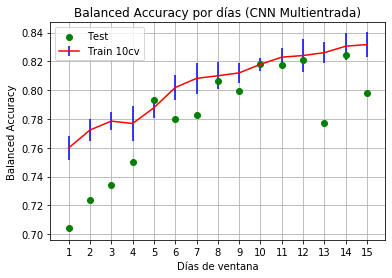

In [32]:
plt.title('Balanced Accuracy por días (CNN Multientrada)')


plt.errorbar(range(1,16),
            mul_bacc_train_list,
             mul_bacc_train_std_list,
             ecolor = 'blue',
            color = 'red',
            alpha = 1,
            zorder = 3,
            label='Train 10cv')

plt.scatter(range(1,16),
            mul_bacc_test_list,
            c = 'green',
            alpha = 1,
            zorder = 3,
            label='Test')


plt.grid(True)
plt.legend(loc = 'upper left')
plt.xlabel('Días de ventana')
plt.xticks(range(1, 16))
plt.ylabel('Balanced Accuracy')
plt.savefig('./cnn_mlp.pdf')
print(mul_bacc_train_list)
print(mul_bacc_train_std_list)
print(mul_bacc_test_list)

# CNN 1-D

In [33]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tensorflow import keras
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.layers import Flatten, Dense, Input, Activation, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
import sklearn
from sklearn import metrics
import pandas as pd
import sys
import numpy as np
from matplotlib import pyplot as plt


# Check gpu
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
    print("Please install GPU version of TF")
    
    
selene = pd.read_csv('./selene_final.csv', index_col = [0, 1])
estratificacion = pd.read_csv('./estratificacion_final.csv', index_col = [0])
    
    
cnn_balanced_accuracy_train = []
cnn_train_std = []
cnn_balanced_accuracy_test = []
test = 0

# Test with all windows
for window in range(1, 16):
    
    print(f'WINDOW: {window}\n\n')

    x = process_selene(selene, estratificacion= estratificacion, ventana = window)
    y = pd.read_csv('./y_final.csv', header = None)
    
    temp_train = []
        
    # 10 CV
    for i in range(10):

        # One-hot labels
        #y = tf.keras.utils.to_categorical(y)
        # Scale features
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(x)

        # Split 80-20
        X_train, X_test, Y_train, Y_test = train_test_split(x_scaled, y, random_state = 42, train_size = 0.8, stratify = y)

        # Reshape for convolutional
        X_train_res = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_test_res = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

        # Better have all metrics in one shot
        METRICS = [
              keras.metrics.TruePositives(name='tp'),
              keras.metrics.FalsePositives(name='fp'),
              keras.metrics.TrueNegatives(name='tn'),
              keras.metrics.FalseNegatives(name='fn'), 
              keras.metrics.BinaryAccuracy(name='accuracy'),
        ]


        # Model
        model = models.Sequential()
        model.add(Conv1D(32, (3), activation='tanh', input_shape=(X_train_res.shape[1],1)))
        model.add(Conv1D(64, (3), activation='tanh'))
        model.add(MaxPooling1D((4)))
        model.add(Flatten())
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(1, activation = 'sigmoid'))

        model.summary()

        # Much default
        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=METRICS)


        n_epoch = 20
        batch = 16

        history = model.fit(X_train_res, Y_train,
                            epochs= n_epoch,
                            batch_size = batch,
                            validation_data= (X_test_res, Y_test),
                            verbose = False
                           #class_weight={1:0.7, 0:0.3}
                           )



        TP = history.history['tp'][n_epoch-1]
        FP = history.history['fp'][n_epoch-1]
        TN = history.history['tn'][n_epoch-1]
        FN = history.history['fn'][n_epoch-1]

        print(f"Baccuracy train:{((TP/(TP+FN))+(TN/(TN+FP)))/2}")
        
        temp_train.append(((TP/(TP+FN))+(TN/(TN+FP)))/2)

        TP = history.history['val_tp'][n_epoch-1]
        FP = history.history['val_fp'][n_epoch-1]
        TN = history.history['val_tn'][n_epoch-1]
        FN = history.history['val_fn'][n_epoch-1]

        test = ((TP/(TP+FN))+(TN/(TN+FP)))/2
    
        print(f"Baccuracy test:{((TP/(TP+FN))+(TN/(TN+FP)))/2}")
        
    
    cnn_balanced_accuracy_train.append(np.mean(temp_train))
    cnn_train_std.append(np.std(temp_train))
    cnn_balanced_accuracy_test.append(test)
    

/usr/local/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py:1717: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
  0%|          | 12/4584 [00:00<00:38, 117.53it/s]

Default GPU Device:/device:GPU:0
WINDOW: 1




100%|██████████| 4584/4584 [00:55<00:00, 81.90it/s]


(68760, 30)

Model: "sequential_150"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 418, 32)           128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 416, 64)           6208      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 104, 64)           0         
_________________________________________________________________
flatten_150 (Flatten)        (None, 6656)              0         
_________________________________________________________________
dense_600 (Dense)            (None, 64)                426048    
_________________________________________________________________
dropout_150 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_601 (Dense)            (None, 1)              

  0%|          | 12/4584 [00:00<00:39, 116.35it/s]

Baccuracy train:0.66483473777771
Baccuracy test:0.6339752078056335
WINDOW: 2




100%|██████████| 4584/4584 [00:56<00:00, 81.44it/s]


(68760, 30)

Model: "sequential_160"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 418, 32)           128       
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 416, 64)           6208      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 104, 64)           0         
_________________________________________________________________
flatten_160 (Flatten)        (None, 6656)              0         
_________________________________________________________________
dense_620 (Dense)            (None, 64)                426048    
_________________________________________________________________
dropout_160 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_621 (Dense)            (None, 1)              

  0%|          | 11/4584 [00:00<00:42, 108.24it/s]

Baccuracy train:0.6877830028533936
Baccuracy test:0.6334782242774963
WINDOW: 3




100%|██████████| 4584/4584 [00:57<00:00, 79.29it/s]


(68760, 30)

Model: "sequential_170"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_40 (Conv1D)           (None, 418, 32)           128       
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 416, 64)           6208      
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 104, 64)           0         
_________________________________________________________________
flatten_170 (Flatten)        (None, 6656)              0         
_________________________________________________________________
dense_640 (Dense)            (None, 64)                426048    
_________________________________________________________________
dropout_170 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_641 (Dense)            (None, 1)              

  0%|          | 12/4584 [00:00<00:39, 116.21it/s]

Baccuracy train:0.7091634273529053
Baccuracy test:0.7036709785461426
WINDOW: 4




100%|██████████| 4584/4584 [00:56<00:00, 81.13it/s]


(68760, 30)

Model: "sequential_180"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 418, 32)           128       
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 416, 64)           6208      
_________________________________________________________________
max_pooling1d_30 (MaxPooling (None, 104, 64)           0         
_________________________________________________________________
flatten_180 (Flatten)        (None, 6656)              0         
_________________________________________________________________
dense_660 (Dense)            (None, 64)                426048    
_________________________________________________________________
dropout_180 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_661 (Dense)            (None, 1)              

  0%|          | 12/4584 [00:00<00:39, 117.17it/s]

Baccuracy train:0.7277714610099792
Baccuracy test:0.684263288974762
WINDOW: 5




100%|██████████| 4584/4584 [00:56<00:00, 81.32it/s]


(68760, 30)

Model: "sequential_190"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_80 (Conv1D)           (None, 418, 32)           128       
_________________________________________________________________
conv1d_81 (Conv1D)           (None, 416, 64)           6208      
_________________________________________________________________
max_pooling1d_40 (MaxPooling (None, 104, 64)           0         
_________________________________________________________________
flatten_190 (Flatten)        (None, 6656)              0         
_________________________________________________________________
dense_680 (Dense)            (None, 64)                426048    
_________________________________________________________________
dropout_190 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_681 (Dense)            (None, 1)              

  0%|          | 12/4584 [00:00<00:39, 114.89it/s]

Baccuracy train:0.7455358505249023
Baccuracy test:0.6880454421043396
WINDOW: 6




100%|██████████| 4584/4584 [00:57<00:00, 79.85it/s]


(68760, 30)

Model: "sequential_200"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_100 (Conv1D)          (None, 418, 32)           128       
_________________________________________________________________
conv1d_101 (Conv1D)          (None, 416, 64)           6208      
_________________________________________________________________
max_pooling1d_50 (MaxPooling (None, 104, 64)           0         
_________________________________________________________________
flatten_200 (Flatten)        (None, 6656)              0         
_________________________________________________________________
dense_700 (Dense)            (None, 64)                426048    
_________________________________________________________________
dropout_200 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_701 (Dense)            (None, 1)              

  0%|          | 11/4584 [00:00<00:44, 103.76it/s]

Baccuracy train:0.7687358260154724
Baccuracy test:0.7760748267173767
WINDOW: 7




100%|██████████| 4584/4584 [00:57<00:00, 80.09it/s]


(68760, 30)

Model: "sequential_210"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_120 (Conv1D)          (None, 418, 32)           128       
_________________________________________________________________
conv1d_121 (Conv1D)          (None, 416, 64)           6208      
_________________________________________________________________
max_pooling1d_60 (MaxPooling (None, 104, 64)           0         
_________________________________________________________________
flatten_210 (Flatten)        (None, 6656)              0         
_________________________________________________________________
dense_720 (Dense)            (None, 64)                426048    
_________________________________________________________________
dropout_210 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_721 (Dense)            (None, 1)              

  0%|          | 12/4584 [00:00<00:38, 117.25it/s]

Baccuracy train:0.7757933139801025
Baccuracy test:0.747708797454834
WINDOW: 8




100%|██████████| 4584/4584 [00:57<00:00, 79.93it/s]


(68760, 30)

Model: "sequential_220"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_140 (Conv1D)          (None, 418, 32)           128       
_________________________________________________________________
conv1d_141 (Conv1D)          (None, 416, 64)           6208      
_________________________________________________________________
max_pooling1d_70 (MaxPooling (None, 104, 64)           0         
_________________________________________________________________
flatten_220 (Flatten)        (None, 6656)              0         
_________________________________________________________________
dense_740 (Dense)            (None, 64)                426048    
_________________________________________________________________
dropout_220 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_741 (Dense)            (None, 1)              

  0%|          | 12/4584 [00:00<00:39, 115.91it/s]

Baccuracy train:0.7849220037460327
Baccuracy test:0.727901041507721
WINDOW: 9




100%|██████████| 4584/4584 [00:56<00:00, 81.27it/s]


(68760, 30)

Model: "sequential_230"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_160 (Conv1D)          (None, 418, 32)           128       
_________________________________________________________________
conv1d_161 (Conv1D)          (None, 416, 64)           6208      
_________________________________________________________________
max_pooling1d_80 (MaxPooling (None, 104, 64)           0         
_________________________________________________________________
flatten_230 (Flatten)        (None, 6656)              0         
_________________________________________________________________
dense_760 (Dense)            (None, 64)                426048    
_________________________________________________________________
dropout_230 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_761 (Dense)            (None, 1)              

  0%|          | 12/4584 [00:00<00:39, 116.00it/s]

Baccuracy train:0.7783139944076538
Baccuracy test:0.7969565987586975
WINDOW: 10




100%|██████████| 4584/4584 [00:57<00:00, 79.76it/s]


(68760, 30)

Model: "sequential_240"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_180 (Conv1D)          (None, 418, 32)           128       
_________________________________________________________________
conv1d_181 (Conv1D)          (None, 416, 64)           6208      
_________________________________________________________________
max_pooling1d_90 (MaxPooling (None, 104, 64)           0         
_________________________________________________________________
flatten_240 (Flatten)        (None, 6656)              0         
_________________________________________________________________
dense_780 (Dense)            (None, 64)                426048    
_________________________________________________________________
dropout_240 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_781 (Dense)            (None, 1)              

  0%|          | 12/4584 [00:00<00:41, 110.50it/s]

Baccuracy train:0.7961220145225525
Baccuracy test:0.765625536441803
WINDOW: 11




100%|██████████| 4584/4584 [00:56<00:00, 81.33it/s]


(68760, 30)

Model: "sequential_250"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_200 (Conv1D)          (None, 418, 32)           128       
_________________________________________________________________
conv1d_201 (Conv1D)          (None, 416, 64)           6208      
_________________________________________________________________
max_pooling1d_100 (MaxPoolin (None, 104, 64)           0         
_________________________________________________________________
flatten_250 (Flatten)        (None, 6656)              0         
_________________________________________________________________
dense_800 (Dense)            (None, 64)                426048    
_________________________________________________________________
dropout_250 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_801 (Dense)            (None, 1)              

  0%|          | 12/4584 [00:00<00:39, 114.51it/s]

Baccuracy train:0.7852071523666382
Baccuracy test:0.7495998740196228
WINDOW: 12




100%|██████████| 4584/4584 [00:56<00:00, 81.37it/s]


(68760, 30)

Model: "sequential_260"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_220 (Conv1D)          (None, 418, 32)           128       
_________________________________________________________________
conv1d_221 (Conv1D)          (None, 416, 64)           6208      
_________________________________________________________________
max_pooling1d_110 (MaxPoolin (None, 104, 64)           0         
_________________________________________________________________
flatten_260 (Flatten)        (None, 6656)              0         
_________________________________________________________________
dense_820 (Dense)            (None, 64)                426048    
_________________________________________________________________
dropout_260 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_821 (Dense)            (None, 1)              

  0%|          | 12/4584 [00:00<00:40, 111.91it/s]

Baccuracy train:0.7985219955444336
Baccuracy test:0.7823082208633423
WINDOW: 13




100%|██████████| 4584/4584 [00:57<00:00, 79.63it/s]


(68760, 30)

Model: "sequential_270"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_240 (Conv1D)          (None, 418, 32)           128       
_________________________________________________________________
conv1d_241 (Conv1D)          (None, 416, 64)           6208      
_________________________________________________________________
max_pooling1d_120 (MaxPoolin (None, 104, 64)           0         
_________________________________________________________________
flatten_270 (Flatten)        (None, 6656)              0         
_________________________________________________________________
dense_840 (Dense)            (None, 64)                426048    
_________________________________________________________________
dropout_270 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_841 (Dense)            (None, 1)              

  0%|          | 11/4584 [00:00<00:41, 109.60it/s]

Baccuracy train:0.8134369850158691
Baccuracy test:0.7943916320800781
WINDOW: 14




100%|██████████| 4584/4584 [00:57<00:00, 80.25it/s]


(68760, 30)

Model: "sequential_280"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_260 (Conv1D)          (None, 418, 32)           128       
_________________________________________________________________
conv1d_261 (Conv1D)          (None, 416, 64)           6208      
_________________________________________________________________
max_pooling1d_130 (MaxPoolin (None, 104, 64)           0         
_________________________________________________________________
flatten_280 (Flatten)        (None, 6656)              0         
_________________________________________________________________
dense_860 (Dense)            (None, 64)                426048    
_________________________________________________________________
dropout_280 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_861 (Dense)            (None, 1)              

  0%|          | 12/4584 [00:00<00:38, 117.64it/s]

Baccuracy train:0.8070151209831238
Baccuracy test:0.7828052043914795
WINDOW: 15




100%|██████████| 4584/4584 [00:56<00:00, 81.06it/s]


(68760, 30)

Model: "sequential_290"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_280 (Conv1D)          (None, 418, 32)           128       
_________________________________________________________________
conv1d_281 (Conv1D)          (None, 416, 64)           6208      
_________________________________________________________________
max_pooling1d_140 (MaxPoolin (None, 104, 64)           0         
_________________________________________________________________
flatten_290 (Flatten)        (None, 6656)              0         
_________________________________________________________________
dense_880 (Dense)            (None, 64)                426048    
_________________________________________________________________
dropout_290 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_881 (Dense)            (None, 1)              

[0.6589444041252136, 0.6810078144073486, 0.7125433444976806, 0.726115745306015, 0.7473310172557831, 0.761453777551651, 0.7752718329429626, 0.7794043362140656, 0.7787073314189911, 0.7903839886188507, 0.7896619379520416, 0.7984564006328583, 0.8056671857833863, 0.8033285796642303, 0.8072123646736145]
[0.0052239523796856376, 0.012784644546523892, 0.007349690958380696, 0.007719769690938039, 0.006866869879177523, 0.009278474340194466, 0.005807117961826609, 0.004864554424400858, 0.006822104187888849, 0.004014982821926521, 0.007600017052371366, 0.008925179719785563, 0.008014164409843021, 0.005675502426712093, 0.008532681667550493]
[0.6339752078056335, 0.6334782242774963, 0.7036709785461426, 0.684263288974762, 0.6880454421043396, 0.7760748267173767, 0.747708797454834, 0.727901041507721, 0.7969565987586975, 0.765625536441803, 0.7495998740196228, 0.7823082208633423, 0.7943916320800781, 0.7828052043914795, 0.8211867213249207]


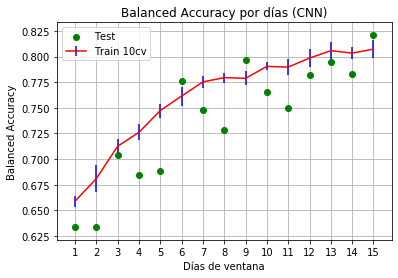

In [34]:
plt.title('Balanced Accuracy por días (CNN)')


plt.errorbar(range(1,16),
            cnn_balanced_accuracy_train,
             cnn_train_std,
             ecolor = 'blue',
            color = 'red',
            alpha = 1,
            zorder = 3,
            label='Train 10cv')

plt.scatter(range(1,16),
            cnn_balanced_accuracy_test,
            c = 'green',
            alpha = 1,
            zorder = 3,
            label='Test')


plt.grid(True)
plt.legend(loc = 'upper left')
plt.xlabel('Días de ventana')
plt.xticks(range(1, 16))
plt.ylabel('Balanced Accuracy')
plt.savefig('./cnn.pdf')
print(cnn_balanced_accuracy_train)
print(cnn_train_std)
print(cnn_balanced_accuracy_test)

## Random Forest

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import pandas as pd
import sys
import numpy as np
from matplotlib import pyplot as plt

y = pd.read_csv('./y_final.csv', header = None)
y = np.ravel(y.values)

selene = pd.read_csv('./selene_final.csv', index_col = [0, 1])
estratificacion = pd.read_csv('./estratificacion_final.csv', index_col = [0])

bests_cv = pd.DataFrame()

bests_test = []

clf = None

for v in range(1,16):

    x = process_selene(selene = selene.copy(), estratificacion=estratificacion.copy(), ventana = v)

    X_train, X_test, Y_train, Y_test = train_test_split(x, y, random_state = 42, train_size = 0.8, stratify = y)
    

    rf=RandomForestClassifier(random_state = 42)
    
    parameters = {'n_estimators': [100, 200, 400],
                 'max_features': ['sqrt', 'log2']}
    
    clf = GridSearchCV(rf, parameters, n_jobs = -1, verbose = True, cv = 10, scoring = 'balanced_accuracy')
    clf.fit(X_train, Y_train)
    df = pd.DataFrame(clf.cv_results_)
    df = df[df['rank_test_score'] == 1]
    
    if bests_cv.empty:
        bests_cv = df.copy()
    else:
        bests_cv = bests_cv.append(df.copy(), ignore_index=True)
        
    
    Y_pred=clf.best_estimator_.predict(X_test)
    bests_test.append(metrics.balanced_accuracy_score(Y_test, Y_pred))

100%|██████████| 4584/4584 [00:56<00:00, 81.44it/s]


(68760, 30)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   23.4s finished
100%|██████████| 4584/4584 [00:57<00:00, 79.42it/s]


(68760, 30)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    7.3s finished
100%|██████████| 4584/4584 [00:57<00:00, 80.15it/s]


(68760, 30)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    7.3s finished
100%|██████████| 4584/4584 [00:56<00:00, 80.77it/s]


(68760, 30)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    7.4s finished
100%|██████████| 4584/4584 [00:57<00:00, 80.13it/s]


(68760, 30)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    7.4s finished
100%|██████████| 4584/4584 [00:56<00:00, 81.36it/s]


(68760, 30)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    7.3s finished
100%|██████████| 4584/4584 [00:57<00:00, 79.80it/s]


(68760, 30)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    7.4s finished
100%|██████████| 4584/4584 [00:57<00:00, 80.13it/s]


(68760, 30)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    7.2s finished
100%|██████████| 4584/4584 [00:56<00:00, 80.50it/s]


(68760, 30)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    7.3s finished
100%|██████████| 4584/4584 [00:55<00:00, 82.14it/s]


(68760, 30)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    7.3s finished
100%|██████████| 4584/4584 [00:56<00:00, 81.38it/s]


(68760, 30)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    7.7s finished
100%|██████████| 4584/4584 [00:57<00:00, 79.96it/s]


(68760, 30)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    7.3s finished
100%|██████████| 4584/4584 [00:57<00:00, 79.51it/s]


(68760, 30)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    7.8s finished
100%|██████████| 4584/4584 [00:56<00:00, 81.71it/s]


(68760, 30)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    7.6s finished
100%|██████████| 4584/4584 [00:56<00:00, 80.81it/s]


(68760, 30)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    7.4s finished


In [36]:
variables_or = selene.columns.append(estratificacion.columns)
variables = variables_or.copy()
for i in range(16):
    variables = variables.append(variables_or)
variables_or

Index(['FC', 'TEMPER', 'SAT', 'TAS', 'TAD', 'TAM', 'FR', 'EDAD', 'SEXO', 'DM',
       'IC', 'EPOC', 'HTA', 'DEP', 'VIH', 'CI', 'ACV', 'IRC', 'CIR', 'OST',
       'ARTROSIS', 'ARTRITIS', 'DEM', 'DC', 'COVID_TTO', 'COVID_REMD_OXIGEN',
       'COVID_REMD_HOSP', 'COVID_REMD_CONSTATES'],
      dtype='object')

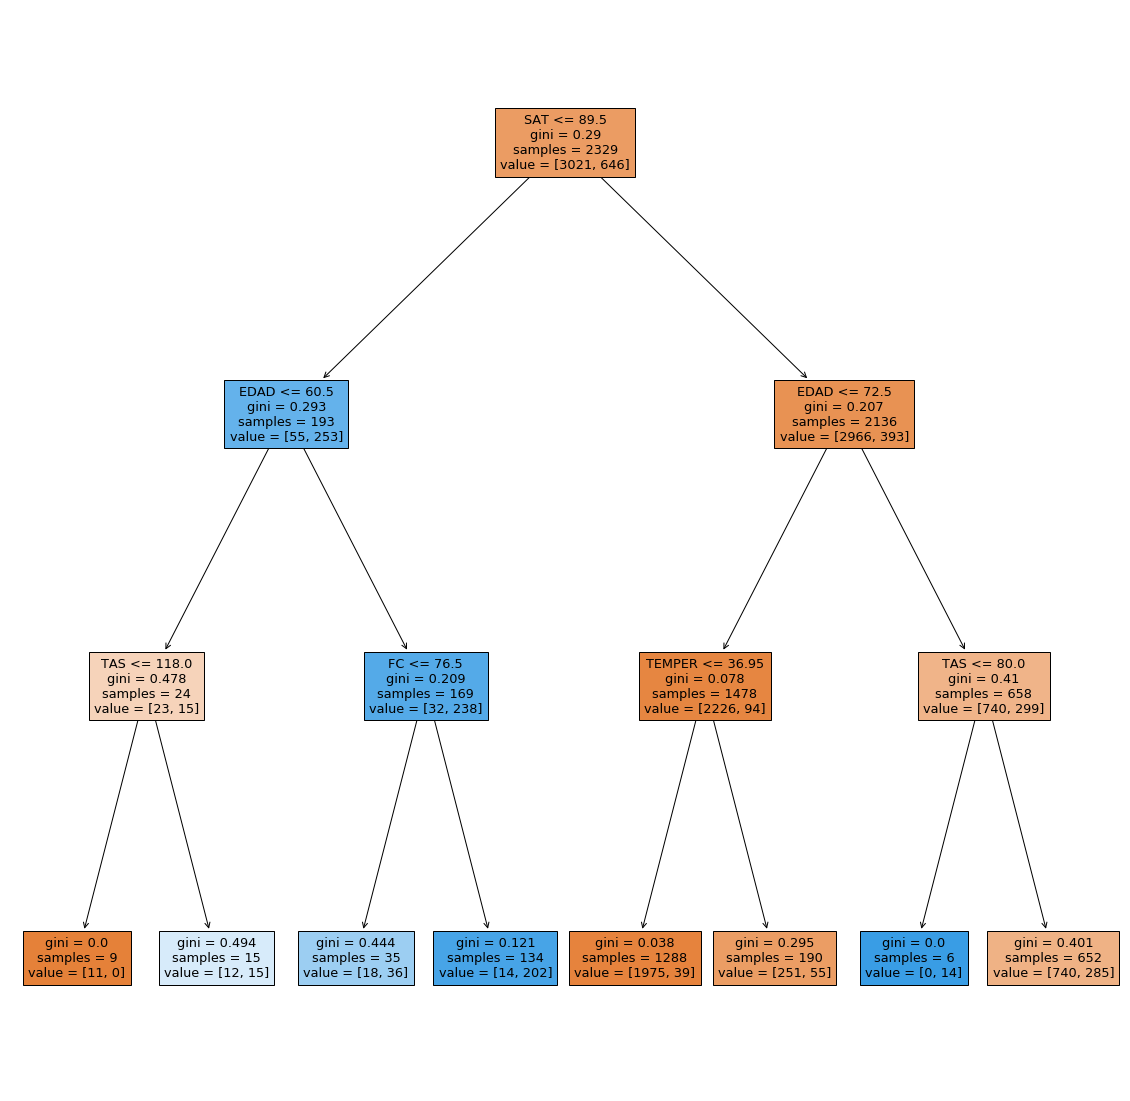

In [37]:
from sklearn import tree

rf=RandomForestClassifier(random_state = 42, max_features = 'sqrt', n_estimators = 400, max_depth = 3)
rf.fit(X_train, Y_train)
arbolito = rf.estimators_[0]
plt.figure(figsize=(20,20))
tree.plot_tree(arbolito, feature_names=variables, filled = True)
plt.savefig('arbolito.pdf')

In [38]:
test = list(bests_cv['mean_test_score'])
test_std = list(bests_cv['std_test_score'])

[0.6523006349714405, 0.6703758128354554, 0.6722553789948165, 0.6900463416716478, 0.7220116051189139, 0.7337943530715559, 0.7476900485392929, 0.755910851737134, 0.759973864901987, 0.7683808885425267, 0.7680753857806866, 0.7749425363050674, 0.7917802278258664, 0.7865137189660206, 0.784096940858227]
[0.028804395441097762, 0.022802773081940755, 0.015656834680519146, 0.017335869789672817, 0.021097502403417644, 0.025709639713475455, 0.022966311956527617, 0.026801407976865706, 0.023682968037506576, 0.031785453452005244, 0.02942682739981772, 0.028213743625910396, 0.024570179683022674, 0.028492377776580077, 0.033377947403301904]
[0.6639753697900873, 0.6841032379797163, 0.6949526601300583, 0.7085902489976077, 0.736122342396981, 0.7324202297921089, 0.7508339229758415, 0.7721158057886047, 0.759872300279659, 0.7920036052427641, 0.7734298662353853, 0.7881414468142458, 0.7804171299572088, 0.8016189898581488, 0.7997279220998013]


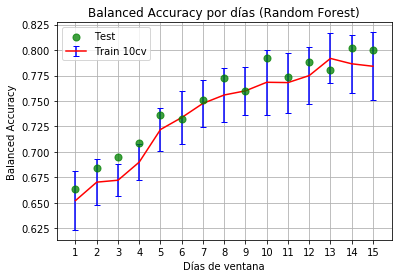

In [39]:
plt.title('Balanced Accuracy por días (Random Forest)')

plt.errorbar(range(1, 16),
             test,
             test_std,
             label = 'Train 10cv',
             ecolor = 'blue',
             color = 'red',
             zorder = 2,
             capsize = 3)


plt.scatter(range(1, 16),
            bests_test,
            c = 'green',
            alpha = 0.75,
            zorder = 3,
            s = 50,
            label='Test')


plt.grid(True)
plt.legend(loc = 'upper left')
plt.xlabel('Días de ventana')
plt.xticks(range(1, 16))
plt.ylabel('Balanced Accuracy')
plt.savefig('./RF.pdf')
print(test)
print(test_std)
print(bests_test)

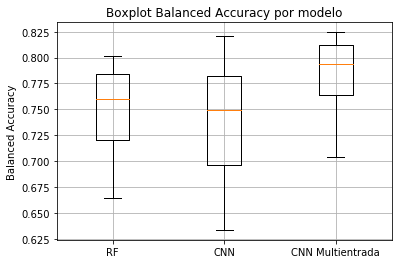

In [40]:
plt.title('Boxplot Balanced Accuracy por modelo')
plt.boxplot([bests_test, cnn_balanced_accuracy_test, mul_bacc_test_list ])
plt.grid(True)
plt.ylabel('Balanced Accuracy')
plt.xticks(range(1,4), ['RF', 'CNN', 'CNN Multientrada'])
plt.savefig('./boxplot.pdf')

# Matrices de confusión

## CNN Multientrada

In [41]:
mul_bacc_train_list = []
mul_bacc_train_std_list = []
mul_bacc_test_list = []
bacc_test = 0

df_resultados = pd.DataFrame()

y = pd.read_csv('./y_final.csv', header = None).values

window_sizes = range(1, 16)
    
selene = pd.read_csv('./selene_final.csv', index_col = [0, 1])
estratificacion = pd.read_csv('./estratificacion_final.csv', index_col = [0])

n_vars = len(selene.columns) + len(estratificacion.columns)

variables_usadas = list(selene.columns)+list(estratificacion.columns)

window = 15

selene_procesado = process_selene(selene, ventana = window)

temp_train = []

    
bacc_train, bacc_test, model, Y_Test, estratificacion_test, selene_test = cnn(selene_procesado, estratificacion, y)

temp_train.append(bacc_train)
    

mul_bacc_train_list.append(np.mean(temp_train))
mul_bacc_train_std_list.append(np.std(temp_train))
mul_bacc_test_list.append(bacc_test)


Y_Test = tf.convert_to_tensor(Y_Test)
Y_Test = tf.reshape(Y_Test, [Y_Test.shape[0]])
prediccion = model.predict([estratificacion_test, selene_test])
tf.math.confusion_matrix(Y_Test, tf.round(prediccion))

100%|██████████| 4584/4584 [00:11<00:00, 401.59it/s]


(68760, 9)

Model: "model_301"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_151 (InputLayer)          [(None, 15, 7, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_150 (Conv2D)             (None, 15, 7, 4)     40          input_151[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_150 (MaxPooling2D (None, 7, 3, 4)      0           conv2d_150[0][0]                 
__________________________________________________________________________________________________
flatten_300 (Flatten)           (None, 84)           0           max_pooling2d_150[0][0]          
__________________________________________________________________________________________

[0.25747240483435835, 111.0, 58.0, 703.0, 45.0, 0.65680474, 0.71153843]

BACC_TRAIN: 0.8364195823669434
BACC_TEST: 0.7942832112312317
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use `tf.cast` instead.


<tf.Tensor: id=41755363, shape=(2, 2), dtype=int32, numpy=
array([[703,  58],
       [ 45, 111]], dtype=int32)>

## CNN 1-Dimensional

In [42]:
selene = pd.read_csv('./selene_final.csv', index_col = [0, 1])
estratificacion = pd.read_csv('./estratificacion_final.csv', index_col = [0])
    
    
cnn_balanced_accuracy_train = []
cnn_train_std = []
cnn_balanced_accuracy_test = []
test = 0

window = 15


x = process_selene(selene, estratificacion= estratificacion, ventana = window)
y = pd.read_csv('./y_final.csv', header = None)

temp_train = []


# One-hot labels
#y = tf.keras.utils.to_categorical(y)
# Scale features
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

# Split 80-20
X_train, X_test, Y_train, Y_test = train_test_split(x_scaled, y, random_state = 42, train_size = 0.8, stratify = y)

# Reshape for convolutional
X_train_res = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_res = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Better have all metrics in one shot
METRICS = [
        keras.metrics.TruePositives(name='tp'),
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.TrueNegatives(name='tn'),
        keras.metrics.FalseNegatives(name='fn'), 
        keras.metrics.BinaryAccuracy(name='accuracy'),
]


# Model
model = models.Sequential()
model.add(Conv1D(32, (3), activation='tanh', input_shape=(X_train_res.shape[1],1)))
model.add(Conv1D(64, (3), activation='tanh'))
model.add(MaxPooling1D((4)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

# Much default
model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=METRICS)


n_epoch = 20
batch = 16

history = model.fit(X_train_res, Y_train,
                    epochs= n_epoch,
                    batch_size = batch,
                    validation_data= (X_test_res, Y_test),
                    #class_weight={1:0.7, 0:0.3}
                    )



TP = history.history['tp'][n_epoch-1]
FP = history.history['fp'][n_epoch-1]
TN = history.history['tn'][n_epoch-1]
FN = history.history['fn'][n_epoch-1]

print(f"Baccuracy train:{((TP/(TP+FN))+(TN/(TN+FP)))/2}")

temp_train.append(((TP/(TP+FN))+(TN/(TN+FP)))/2)

TP = history.history['val_tp'][n_epoch-1]
FP = history.history['val_fp'][n_epoch-1]
TN = history.history['val_tn'][n_epoch-1]
FN = history.history['val_fn'][n_epoch-1]

test = ((TP/(TP+FN))+(TN/(TN+FP)))/2

print(f"Baccuracy test:{((TP/(TP+FN))+(TN/(TN+FP)))/2}")
    

cnn_balanced_accuracy_train.append(np.mean(temp_train))
cnn_train_std.append(np.std(temp_train))
cnn_balanced_accuracy_test.append(test)

Y_test = tf.convert_to_tensor(Y_test.values)
Y_test = tf.reshape(Y_Test, [Y_test.shape[0]])
prediccion = model.predict(X_test_res)
prediccion = tf.round(prediccion)
prediccion = tf.reshape(prediccion, [prediccion.shape[0]])
tf.math.confusion_matrix(Y_Test, prediccion)

100%|██████████| 4584/4584 [00:57<00:00, 79.72it/s]


(68760, 30)

Model: "sequential_301"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_300 (Conv1D)          (None, 418, 32)           128       
_________________________________________________________________
conv1d_301 (Conv1D)          (None, 416, 64)           6208      
_________________________________________________________________
max_pooling1d_150 (MaxPoolin (None, 104, 64)           0         
_________________________________________________________________
flatten_301 (Flatten)        (None, 6656)              0         
_________________________________________________________________
dense_904 (Dense)            (None, 64)                426048    
_________________________________________________________________
dropout_301 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_905 (Dense)            (None, 1)              

<tf.Tensor: id=41848700, shape=(2, 2), dtype=int32, numpy=
array([[740,  21],
       [ 59,  97]], dtype=int32)>

## Random Forest

In [43]:
from sklearn.metrics import confusion_matrix
y = pd.read_csv('./y_final.csv', header = None)
y = np.ravel(y.values)

selene = pd.read_csv('./selene_final.csv', index_col = [0, 1])
estratificacion = pd.read_csv('./estratificacion_final.csv', index_col = [0])

bests_cv = pd.DataFrame()

bests_test = []

clf = None



x = process_selene(selene = selene.copy(), estratificacion=estratificacion.copy(), ventana = 15)

X_train, X_test, Y_train, Y_test = train_test_split(x, y, random_state = 42, train_size = 0.8, stratify = y)


rf=RandomForestClassifier(random_state = 42)

parameters = {'n_estimators': [100, 200, 400],
                'max_features': ['sqrt', 'log2']}

clf = GridSearchCV(rf, parameters, n_jobs = -1, verbose = True, cv = 10, scoring = 'balanced_accuracy')
clf.fit(X_train, Y_train)
df = pd.DataFrame(clf.cv_results_)
df = df[df['rank_test_score'] == 1]

if bests_cv.empty:
    bests_cv = df.copy()
else:
    bests_cv = bests_cv.append(df.copy(), ignore_index=True)
    

Y_pred=clf.best_estimator_.predict(X_test)
bests_test.append(metrics.balanced_accuracy_score(Y_test, Y_pred))

confusion_matrix(Y_Test, Y_pred)

100%|██████████| 4584/4584 [00:55<00:00, 82.69it/s]


(68760, 30)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    7.5s finished


array([[744,  17],
       [ 59,  97]])